In [ ]:
import os
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge

warnings.filterwarnings('ignore')


In [828]:
# Set working directory 
data_dir = Path("data/raw")
os.makedirs(data_dir, exist_ok=True)  # Ensure directory exists

# List of datasets to load (excluding nuts_shapes, which is GeoJSON)
csv_datasets = [
    "energy_balances.csv",
    "renewable_stats.csv",
    "energy_efficiency.csv",
    "regional_energy.csv",
    "regional_gdp.csv",
    "rd_expenditure.csv",
    "education_stats.csv",
    "employment_stats.csv",
    "emissions_regional.csv",
    "air_quality.csv",
    "data_summary.csv"
]

# Dictionary to store loaded datasets
datasets = {}

# Load CSV datasets
print("📊 Loading CSV datasets...")
for file in csv_datasets:
    file_path = data_dir / file
    try:
        datasets[file.replace(".csv", "")] = pd.read_csv(file_path, encoding='utf-8')
        print(f"   ✓ Loaded {file}: {datasets[file.replace('.csv', '')].shape}")
    except FileNotFoundError:
        print(f"   ⚠ File {file} not found in {data_dir}")
    except Exception as e:
        print(f"   ⚠ Error loading {file}: {e}")

# Load NUTS shapes (GeoJSON)
print("🗺️ Loading NUTS geographic data...")
try:
    nuts_shapes = gpd.read_file(data_dir / "nuts_shapes.geojson")
    print(f"   ✓ Loaded nuts_shapes.geojson: {nuts_shapes.shape}")
except FileNotFoundError:
    print(f"   ⚠ File nuts_shapes.geojson not found in {data_dir}")
except Exception as e:
    print(f"   ⚠ Error loading nuts_shapes.geojson: {e}")

# Optional: Load NUTS shapes attribute table (CSV) if needed
try:
    nuts_shapes_attributes = pd.read_csv(data_dir / "nuts_shapes_attributes.csv", encoding='utf-8')
    print(f"   ✓ Loaded nuts_shapes_attributes.csv: {nuts_shapes_attributes.shape}")
except FileNotFoundError:
    print(f"   ⚠ File nuts_shapes_attributes.csv not found in {data_dir}")
except Exception as e:
    print(f"   ⚠ Error loading nuts_shapes_attributes.csv: {e}")

# Display basic information about each dataset
datasets["data_summary"]

📊 Loading CSV datasets...
   ✓ Loaded energy_balances.csv: (38360010, 7)
   ✓ Loaded renewable_stats.csv: (2975, 6)
   ✓ Loaded energy_efficiency.csv: (13710, 6)
   ✓ Loaded regional_energy.csv: (4246356, 7)
   ✓ Loaded regional_gdp.csv: (279563, 5)
   ✓ Loaded rd_expenditure.csv: (305467, 6)
   ✓ Loaded education_stats.csv: (643885, 8)
   ✓ Loaded employment_stats.csv: (420548, 7)
   ✓ Loaded emissions_regional.csv: (4997964, 7)
   ✓ Loaded air_quality.csv: (6512, 7)
   ✓ Loaded data_summary.csv: (11, 6)
🗺️ Loading NUTS geographic data...
   ✓ Loaded nuts_shapes.geojson: (334, 12)
   ✓ Loaded nuts_shapes_attributes.csv: (334, 11)


,Dataset,Rows,Columns,Time_Range,Missing_Values,Countries
0,Energy Balances,38360010,7,No time variable,17698503,41
1,Renewable Energy,2975,6,No time variable,0,39
2,Energy Efficiency,13710,6,No time variable,0,41
3,Regional Energy,4246356,7,No time variable,1459446,41
4,Regional GDP,279563,5,No time variable,0,35
5,R&D Expenditure,305467,6,No time variable,20102,44
6,Education,643885,8,No time variable,28944,38
7,Employment,420548,7,No time variable,8575,38
8,Emissions,4997964,7,No time variable,8160,33
9,Air Quality,6512,7,No time variable,0,28


In [829]:
datasets["data_summary"].drop("Time_Range",axis=1)

,Dataset,Rows,Columns,Missing_Values,Countries
0,Energy Balances,38360010,7,17698503,41
1,Renewable Energy,2975,6,0,39
2,Energy Efficiency,13710,6,0,41
3,Regional Energy,4246356,7,1459446,41
4,Regional GDP,279563,5,0,35
5,R&D Expenditure,305467,6,20102,44
6,Education,643885,8,28944,38
7,Employment,420548,7,8575,38
8,Emissions,4997964,7,8160,33
9,Air Quality,6512,7,0,28


In [556]:
print(datasets["employment_stats"].head())

  freq     unit sex     age geo time_period  values  year
0    A  THS_PER   F  Y15-24  AT  1999-01-01   234.4  1999
1    A  THS_PER   F  Y15-24  AT  2000-01-01   222.6  2000
2    A  THS_PER   F  Y15-24  AT  2001-01-01   215.6  2001
3    A  THS_PER   F  Y15-24  AT  2002-01-01   218.5  2002
4    A  THS_PER   F  Y15-24  AT  2003-01-01   217.9  2003


In [557]:
print(datasets["employment_stats"]["unit"].unique())

['THS_PER']


In [555]:
print(datasets["rd_expenditure"].head())

  freq sectperf     unit geo time_period  values  year
0    A      BES  EUR_HAB  AL  2021-01-01   3.045  2021
1    A      BES  EUR_HAB  AL  2022-01-01   4.751  2022
2    A      BES  EUR_HAB  AT  1981-01-01  51.466  1981
3    A      BES  EUR_HAB  AT  1984-01-01  73.162  1984
4    A      BES  EUR_HAB  AT  1985-01-01  79.528  1985


In [572]:
print(datasets["rd_expenditure"]["unit"].unique())

['EUR_HAB' 'MIO_EUR' 'MIO_NAC' 'MIO_PPS' 'MIO_PPS_KP05' 'PC_GDP'
 'PPS_HAB_KP05']


In [562]:
print(datasets["air_quality"].head())

  freq airpol nace_r2    unit        geo time_period  values  year
0    Q    GHG       A  PCH_SM  EU27_2020  2011-01-01  -0.558  2011
1    Q    GHG       A  PCH_SM  EU27_2020  2011-04-01  -0.479  2011
2    Q    GHG       A  PCH_SM  EU27_2020  2011-07-01  -0.119  2011
3    Q    GHG       A  PCH_SM  EU27_2020  2011-10-01   0.128  2011
4    Q    GHG       A  PCH_SM  EU27_2020  2012-01-01  -0.448  2012


In [561]:
print(datasets["air_quality"]["geo"].unique())

['EU27_2020' 'AT' 'BE' 'BG' 'CY' 'CZ' 'DE' 'DK' 'EE' 'EL' 'ES' 'FI' 'FR'
 'HR' 'HU' 'IE' 'IT' 'LT' 'LU' 'LV' 'MT' 'NL' 'PL' 'PT' 'RO' 'SE' 'SI'
 'SK']


In [563]:
print(datasets["education_stats"].head())

  freq sex isced11     age unit geo time_period  values  year
0    A   F   ED0-2  Y20-24   PC  AT  2000-01-01    15.1  2000
1    A   F   ED0-2  Y20-24   PC  AT  2001-01-01    14.7  2001
2    A   F   ED0-2  Y20-24   PC  AT  2002-01-01    15.4  2002
3    A   F   ED0-2  Y20-24   PC  AT  2003-01-01    16.6  2003
4    A   F   ED0-2  Y20-24   PC  AT  2004-01-01    13.8  2004


In [571]:
print(datasets["transport_networks"].head())

  freq tra_infr unit geo time_period  values  year
0    A      CNL   KM  AT  1990-01-01     NaN  1990
1    A      CNL   KM  AT  1991-01-01     NaN  1991
2    A      CNL   KM  AT  1992-01-01     NaN  1992
3    A      CNL   KM  AT  1993-01-01     NaN  1993
4    A      CNL   KM  AT  1994-01-01     NaN  1994


---

# EDA

In [299]:
### Standardize time columns to 'year' ###
print("Standardizing time columns to 'year'...")
for name, df in datasets.items():
    if "time_period" in df.columns:
        # Check if time_period is numeric (int64 or float64)
        if df["time_period"].dtype in ["int64", "float64"]:
            df["year"] = df["time_period"].astype(int)  # Directly use as year
            print(f"   ✓ Added 'year' column to {name} from 'time_period' (numeric)")
        else:
            # Assume string date format (e.g., '2005-01-01')
            df["year"] = pd.to_datetime(df["time_period"], errors='coerce').dt.year
            print(f"   ✓ Added 'year' column to {name} from 'time_period' (date string)")
    elif "year" in df.columns:
        df["year"] = df["year"].astype(int)  # Ensure integer
        print(f"   ✓ Ensured 'year' is integer in {name}")
    datasets[name] = df

Standardizing time columns to 'year'...
   ✓ Added 'year' column to energy_balances from 'time_period' (date string)
   ✓ Added 'year' column to renewable_stats from 'time_period' (numeric)
   ✓ Added 'year' column to energy_efficiency from 'time_period' (numeric)
   ✓ Added 'year' column to regional_energy from 'time_period' (numeric)
   ✓ Added 'year' column to regional_gdp from 'time_period' (date string)
   ✓ Added 'year' column to rd_expenditure from 'time_period' (date string)
   ✓ Added 'year' column to education_stats from 'time_period' (date string)
   ✓ Added 'year' column to employment_stats from 'time_period' (date string)
   ✓ Added 'year' column to emissions_regional from 'time_period' (date string)
   ✓ Added 'year' column to air_quality from 'time_period' (date string)
   ✓ Added 'year' column to transport_networks from 'time_period' (date string)


In [300]:
### Check available years ###
print("Available years in key datasets:")
for name in ["renewable_stats", "emissions_regional", "regional_gdp", "energy_efficiency"]:
    if "year" in datasets[name].columns:
        print(f"{name}: {sorted(datasets[name]['year'].unique())}")

Available years in key datasets:
renewable_stats: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
emissions_regional: [1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
regional_gdp: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
energy_efficiency: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [342]:
datasets["emissions_regional"]["country"].unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'EU', 'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV',
       'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'TR'],
      dtype=object)

In [351]:
datasets["renewable_stats"]["geo"].unique()

array(['AL', 'AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EA20', 'EE',
       'EL', 'ES', 'EU27_2020', 'FI', 'FR', 'GE', 'HR', 'HU', 'IE', 'IS',
       'IT', 'LT', 'LU', 'LV', 'MD', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL',
       'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'XK'], dtype=object)

In [348]:
### Aggregate to country level ###

# Create country code from geo (first two characters)
for name in ["emissions_regional"]:
    datasets[name]["country"] = datasets[name]["geo"].str[:2]

# Aggregate emissions_regional (GHG only, sum values by country and year)
emissions_country = (
    datasets["emissions_regional"]
    .loc[
        (datasets["emissions_regional"]["airpol"] == "GHG") &
        (datasets["emissions_regional"]["country"] != "EU")
    ]
    .groupby(["country", "year"])["values"]
    .sum()
    .reset_index()
)


# For renewable_stats and energy_efficiency, assume country-level data (geo = 2 chars)
renewable_country = datasets["renewable_stats"].loc[
    (datasets["renewable_stats"]["nrg_bal"] == "REN") &
    (datasets["renewable_stats"]["geo"].str.len() == 2) &
    (datasets["renewable_stats"]["geo"] != "EU")
]

---

### Energy efficency aggregation    

| **Code**         | **Meaning**                                              | **Type of Consumption** | **Reference Year**                                              |
|------------------|----------------------------------------------------------|--------------------------|------------------------------------------------------------------|
| **FEC_DT2020**   | Final Energy Consumption – **Domestic Target 2020**      | Final consumption        | National target for 2020                                        |
| **FEC_DT2030**   | Final Energy Consumption – **Domestic Target 2030**      | Final consumption        | National target for 2030                                        |
| **FEC_EED**      | Final Energy Consumption – **EED Target**                | Final consumption        | Target set by the **Energy Efficiency Directive (EED)**         |
| **PEC_DT2020**   | Primary Energy Consumption – **Domestic Target 2020**    | Primary consumption      | National target for 2020                                        |
| **PEC_DT2030**   | Primary Energy Consumption – **Domestic Target 2030**    | Primary consumption      | National target for 2030                                        |
| **PEC_EED**      | Primary Energy Consumption – **EED Target**              | Primary consumption      | Target set by the **Energy Efficiency Directive (EED)**         |


In [337]:
datasets["energy_efficiency"]["nrg_bal"].unique()

array(['FEC2020-2030', 'FEC_DT2020', 'FEC_DT2030', 'FEC_EED',
       'PEC2020-2030', 'PEC_DT2020', 'PEC_DT2030', 'PEC_EED'],
      dtype=object)


FEC_EED: Final Energy Consumption according to the Energy Efficiency Directive. This indicator measures actual energy use and is directly linked to the EU's energy efficiency policies, making it suitable for trend charts and cross-country comparisons.

##### 2 Different units:

* MTOE (Million Tonnes of Oil Equivalent): A standard unit used by Eurostat to measure and compare energy consumption from different sources, converting everything into the equivalent energy of burning oil.

* I05 Index: An indicator showing how a country’s energy consumption has changed over time compared to the year 2005, where a value of 100 means the same level as in 2005.

##

It is complementary to nrg_bal == "REN" used in the renewable_country dataset, which measures the share of renewables in final energy consumption.

In [338]:
energy_eff_country_MTOE = datasets["energy_efficiency"].loc[
    (datasets["energy_efficiency"]["nrg_bal"] == "FEC_EED") &
    (datasets["energy_efficiency"]["unit"] == "MTOE") &
    (datasets["energy_efficiency"]["geo"].str.len() == 2) &
    (datasets["energy_efficiency"]["geo"] != "EU")
]

energy_eff_country_IO5 = datasets["energy_efficiency"].loc[
    (datasets["energy_efficiency"]["nrg_bal"] == "FEC_EED") &
    (datasets["energy_efficiency"]["unit"] == "I05") &
    (datasets["energy_efficiency"]["geo"].str.len() == 2) &
    (datasets["energy_efficiency"]["geo"] != "EU")
]

---

### GDP aggregation

In [302]:
datasets["regional_gdp"]["unit"].unique()

array(['EUR_HAB', 'EUR_HAB_EU27_2020', 'MIO_EUR', 'MIO_NAC',
       'MIO_PPS_EU27_2020', 'PPS_EU27_2020_HAB', 'PPS_HAB_EU27_2020'],
      dtype=object)

In [303]:
# Aggregate regional_gdp (use NUTS 0 with MIO_EUR if available, else NUTS 2)
gdp_country = (
    datasets["regional_gdp"]
    .loc[
        (datasets["regional_gdp"]["unit"] == "MIO_EUR") &  # Only total GDP in million EUR
        (datasets["regional_gdp"]["geo"].str.len() == 2) &  # Try NUTS 0
        (datasets["regional_gdp"]["country"] != "EU")  # Exclude EU aggregates
    ]
    [["geo", "year", "values"]]  # Select relevant columns
    .rename(columns={"geo": "country"})  # Rename geo to country
)

# Fallback: If NUTS 0 is empty, aggregate NUTS 2
if gdp_country.empty:
    print("No NUTS 0 data found for MIO_EUR, aggregating NUTS 2...")
    gdp_country = (
        datasets["regional_gdp"]
        .loc[
            (datasets["regional_gdp"]["unit"] == "MIO_EUR") &  # Only total GDP in million EUR
            (datasets["regional_gdp"]["geo"].str.len() == 4) &  # NUTS 2
            (datasets["regional_gdp"]["country"] != "EU")  # Exclude EU aggregates
        ]
        .groupby(["country", "year"])["values"]
        .sum()  # Sum for total GDP
        .reset_index()
    )

---

## Filtering

In [382]:
### Filter for 2010–2023 ###
years = range(2010, 2024)  # Analyse only 2010 - 2023 time range
renewable_country = renewable_country[renewable_country["year"].isin(years)]
emissions_country = emissions_country[emissions_country["year"].isin(years)]
gdp_country = gdp_country[gdp_country["year"].isin(years)]
energy_eff_country_MTOE = energy_eff_country_MTOE[energy_eff_country_MTOE["year"].isin(years)]
energy_eff_country_IO5 = energy_eff_country_IO5[energy_eff_country_IO5["year"].isin(years)]

In [385]:
renewable_country[renewable_country["year"]==2023].head()

,freq,nrg_bal,unit,geo,time_period,values,year
19,A,REN,PC,AL,2023,46.620,2023
39,A,REN,PC,AT,2023,40.844,2023
67,A,REN,PC,BE,2023,14.741,2023
87,A,REN,PC,BG,2023,22.549,2023
107,A,REN,PC,CY,2023,20.213,2023


In [375]:
### Select top 5 and bottom 5 countries (for renewables and efficiency) ###
# Based on average 2010–2020 --> WHY 2020????
renewable_avg = renewable_country[renewable_country["year"] <= 2020].groupby("geo")["values"].mean().sort_values()
top5_renew = renewable_avg.tail(5).index.tolist()
bottom5_renew = renewable_avg.head(5).index.tolist()

energy_eff_avg_MTOE = energy_eff_country_MTOE[energy_eff_country_MTOE["year"] <= 2020].groupby("geo")["values"].mean().sort_values()
top5_eff_MTOE = energy_eff_avg_MTOE.tail(5).index.tolist()
bottom5_eff_MTOE = energy_eff_avg_MTOE.head(5).index.tolist()

energy_eff_avg_IO5 = energy_eff_country_IO5[energy_eff_country_IO5["year"] <= 2020].groupby("geo")["values"].mean().sort_values()
top5_eff_IO5 = energy_eff_avg_IO5.tail(5).index.tolist()
bottom5_eff_IO5 = energy_eff_avg_IO5.head(5).index.tolist()

# For emissions and GDP, select top 5 countries (largest emitters/economies)
emissions_avg = emissions_country[emissions_country["year"] <= 2020].groupby("country")["values"].mean().sort_values()
top5_emiss = emissions_avg.tail(5).index.tolist()
bottom5_emiss = emissions_avg.head(5).index.tolist()

gdp_avg = gdp_country[gdp_country["year"] <= 2020].groupby("country")["values"].mean().sort_values()
top5_gdp = gdp_avg.tail(5).index.tolist()

In [307]:
renewable_avg[0:5]

geo
MT    5.418091
LU    5.546818
NL    6.504727
BE    8.494727
IE    9.390818
Name: values, dtype: float64

In [308]:
top5_emiss

['PL', 'IT', 'TR', 'FR', 'DE']

In [309]:
### Compute EU average/total ###
eu_renew = datasets["renewable_stats"][
    (datasets["renewable_stats"]["nrg_bal"] == "REN") & 
    (datasets["renewable_stats"]["geo"] == "EU27_2020")
]

eu_eff_MTOE = datasets["energy_efficiency"][
    (datasets["energy_efficiency"]["nrg_bal"] == "FEC_EED") & 
    (datasets["energy_efficiency"]["unit"] == "MTOE") &
    (datasets["energy_efficiency"]["geo"] == "EU27_2020")
]

eu_eff_IO5 = datasets["energy_efficiency"][
    (datasets["energy_efficiency"]["nrg_bal"] == "FEC_EED") & 
    (datasets["energy_efficiency"]["unit"] == "I05") &
    (datasets["energy_efficiency"]["geo"] == "EU27_2020")
]

eu_renew = eu_renew[eu_renew["year"].isin(years)]
eu_eff_MTOE = eu_eff_MTOE[eu_eff_MTOE["year"].isin(years)]
eu_eff_IO5 = eu_eff_IO5[eu_eff_IO5["year"].isin(years)]

eu_emiss = emissions_country.groupby("year")["values"].sum().reset_index()
eu_emiss["country"] = "EU27_2020"
eu_gdp = gdp_country.groupby("year")["values"].sum().reset_index()
eu_gdp["country"] = "EU27_2020"

In [310]:
eu_renew.tail()

,freq,nrg_bal,unit,geo,time_period,values,year
246,A,REN,PC,EU27_2020,2019,19.887,2019
247,A,REN,PC,EU27_2020,2020,22.038,2020
248,A,REN,PC,EU27_2020,2021,21.894,2021
249,A,REN,PC,EU27_2020,2022,23.058,2022
250,A,REN,PC,EU27_2020,2023,24.555,2023


In [311]:
eu_emiss.tail()

,year,values,country
9,2019,1.752834e+10,EU27_2020
10,2020,1.609067e+10,EU27_2020
11,2021,1.694699e+10,EU27_2020
12,2022,1.670393e+10,EU27_2020
13,2023,1.340278e+10,EU27_2020


In [312]:
eu_gdp.tail()

,year,values,country
9,2019,15881469.43,EU27_2020
10,2020,15248734.45,EU27_2020
11,2021,16685493.30,EU27_2020
12,2022,17088740.78,EU27_2020
13,2023,18321044.06,EU27_2020


In [313]:
eu_eff_MTOE.tail()

,freq,nrg_bal,unit,geo,time_period,values,year
6370,A,FEC_EED,MTOE,EU27_2020,2019,968.67,2019
6371,A,FEC_EED,MTOE,EU27_2020,2020,891.32,2020
6372,A,FEC_EED,MTOE,EU27_2020,2021,947.67,2021
6373,A,FEC_EED,MTOE,EU27_2020,2022,921.49,2022
6374,A,FEC_EED,MTOE,EU27_2020,2023,893.68,2023


In [314]:
eu_eff_IO5.tail()

,freq,nrg_bal,unit,geo,time_period,values,year
5676,A,FEC_EED,I05,EU27_2020,2019,95.23,2019
5677,A,FEC_EED,I05,EU27_2020,2020,87.63,2020
5678,A,FEC_EED,I05,EU27_2020,2021,93.17,2021
5679,A,FEC_EED,I05,EU27_2020,2022,90.59,2022
5680,A,FEC_EED,I05,EU27_2020,2023,87.86,2023


In [449]:
country_code_to_name = {
    'AL': 'Albania',
    'AT': 'Austria',
    'BA': 'Bosnia and Herzegovina',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CY': 'Cyprus',
    'CZ': 'Czechia',
    'DE': 'Germany',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'EL': 'Greece',            # 'EL' is the Eurostat code for Greece (normally 'GR')
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'GE': 'Georgia',
    'HR': 'Croatia',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IS': 'Iceland',
    'IT': 'Italy',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'LV': 'Latvia',
    'MD': 'Moldova',
    'ME': 'Montenegro',
    'MK': 'North Macedonia',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'RS': 'Serbia',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'SK': 'Slovakia',
    'XK': 'Kosovo'
}


### Total GDP Plots

In [315]:
### Set style for plots ###
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12, "figure.figsize": (12, 6)})

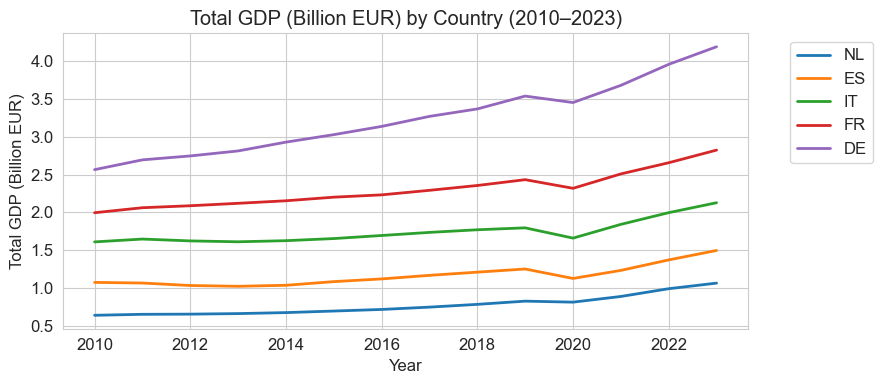

In [320]:
### Total GDP - Line Plot ###
plt.figure(figsize=(9, 4))
for country in top5_gdp:
    data = gdp_country[gdp_country["country"] == country]
    plt.plot(data["year"], data["values"] / 1e6, label=country, linewidth=2)  # Convert to billion EUR
plt.title("Total GDP (Billion EUR) by Country (2010–2023)")
plt.xlabel("Year")
plt.ylabel("Total GDP (Billion EUR)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

---

# Energy transition patterns from 2010 to 2024 in the EU Countries

In [386]:
# Set plot style
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12, "figure.figsize": (9, 4)})

In [433]:
### Add EU27_2020 data to country-level DataFrames ###
renewable_country_with_eu = pd.concat([
    renewable_country[["geo", "year", "values"]].rename(columns={"values": "renewable_share"}),
    eu_renew[["geo", "year", "values"]].rename(columns={"values": "renewable_share"})
])

energy_eff_country_mtoe_with_eu = pd.concat([
    energy_eff_country_MTOE[["geo", "year", "values"]].rename(columns={"values": "energy_consumption_mtoe"}),
    eu_eff_MTOE[["geo", "year", "values"]].rename(columns={"values": "energy_consumption_mtoe"})
])

emissions_country_with_eu = pd.concat([
    emissions_country[["country", "year", "values"]].rename(columns={"country": "geo", "values": "ghg_emissions"}),
    eu_emiss[["country", "year", "values"]].rename(columns={"country": "geo", "values": "ghg_emissions"})
])

In [389]:
### Handle missing values (fill with mean for each geo) ###
renewable_country_with_eu["renewable_share"] = renewable_country_with_eu.groupby("geo")["renewable_share"].transform(lambda x: x.fillna(x.mean()))
energy_eff_country_mtoe_with_eu["energy_consumption_mtoe"] = energy_eff_country_mtoe_with_eu.groupby("geo")["energy_consumption_mtoe"].transform(lambda x: x.fillna(x.mean()))
emissions_country_with_eu["ghg_emissions"] = emissions_country_with_eu.groupby("geo")["ghg_emissions"].transform(lambda x: x.fillna(x.mean()))

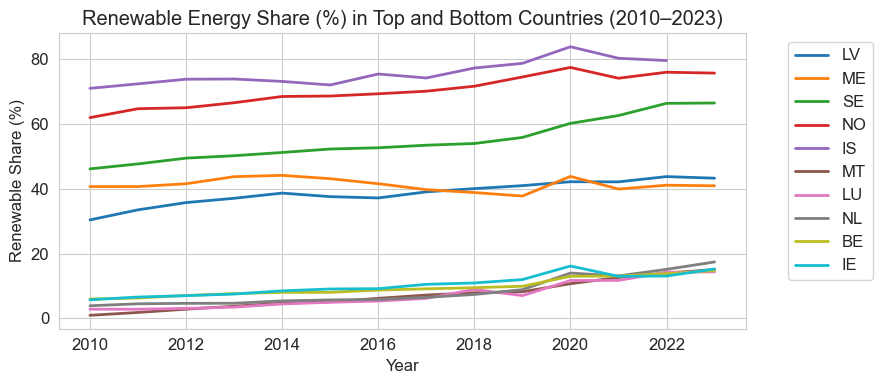

In [ ]:
# Line Plots for Top 5 and Bottom 5 Countries + EU27_2020
# Renewable Share
plt.figure()
for country in top5_renew + bottom5_renew:
    data = renewable_country_with_eu[renewable_country_with_eu["geo"] == country]
    plt.plot(data["year"], data["renewable_share"], label=country, linewidth=2)
plt.title("Renewable Energy Share (%) in Top and Bottom Countries (2010–2023)")
plt.xlabel("Year")
plt.ylabel("Renewable Share (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

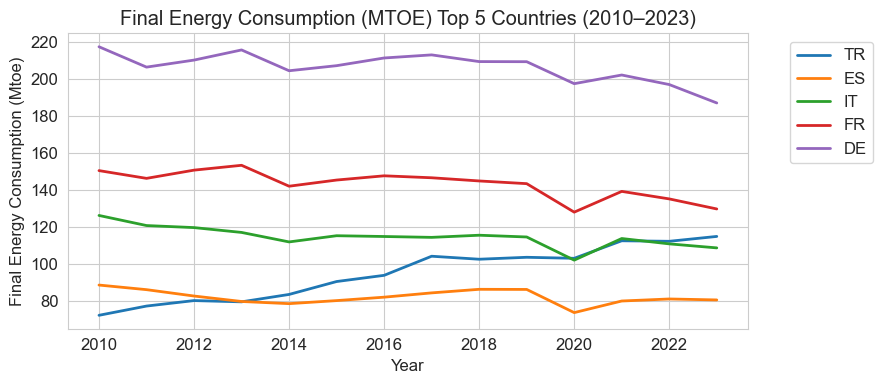

In [399]:
# Energy Efficiency (MTOE) -- Top Countries
plt.figure()
for country in top5_eff_MTOE:
    data = energy_eff_country_mtoe_with_eu[energy_eff_country_mtoe_with_eu["geo"] == country]
    plt.plot(data["year"], data["energy_consumption_mtoe"], label=country, linewidth=2)
plt.title("Final Energy Consumption (MTOE) Top 5 Countries (2010–2023)")
plt.xlabel("Year")
plt.ylabel("Final Energy Consumption (Mtoe)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

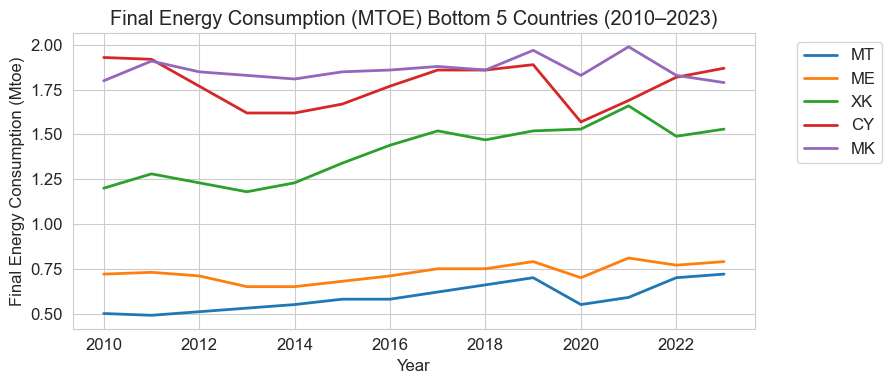

In [400]:
# Energy Efficiency (MTOE) -- Bottom Countries
plt.figure()
for country in bottom5_eff_MTOE:
    data = energy_eff_country_mtoe_with_eu[energy_eff_country_mtoe_with_eu["geo"] == country]
    plt.plot(data["year"], data["energy_consumption_mtoe"], label=country, linewidth=2)
plt.title("Final Energy Consumption (MTOE) Bottom 5 Countries (2010–2023)")
plt.xlabel("Year")
plt.ylabel("Final Energy Consumption (Mtoe)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

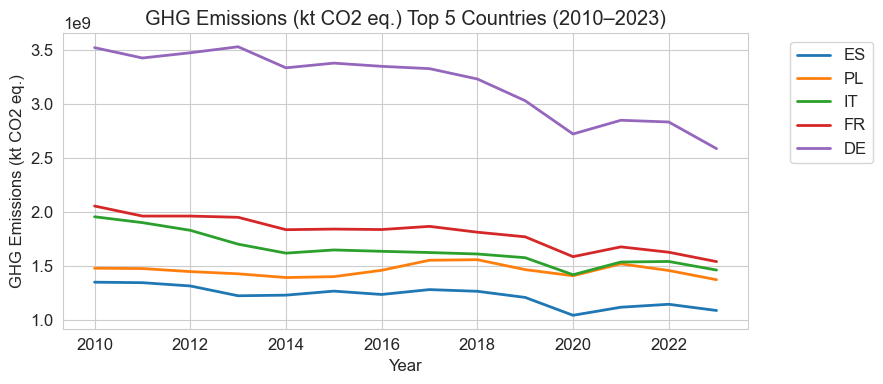

In [397]:
# Emissions (GHG)
plt.figure()
for country in top5_emiss:
    data = emissions_country_with_eu[emissions_country_with_eu["geo"] == country]
    plt.plot(data["year"], data["ghg_emissions"], label=country, linewidth=2)
plt.title("GHG Emissions (kt CO2 eq.) Top 5 Countries (2010–2023)")
plt.xlabel("Year")
plt.ylabel("GHG Emissions (kt CO2 eq.)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

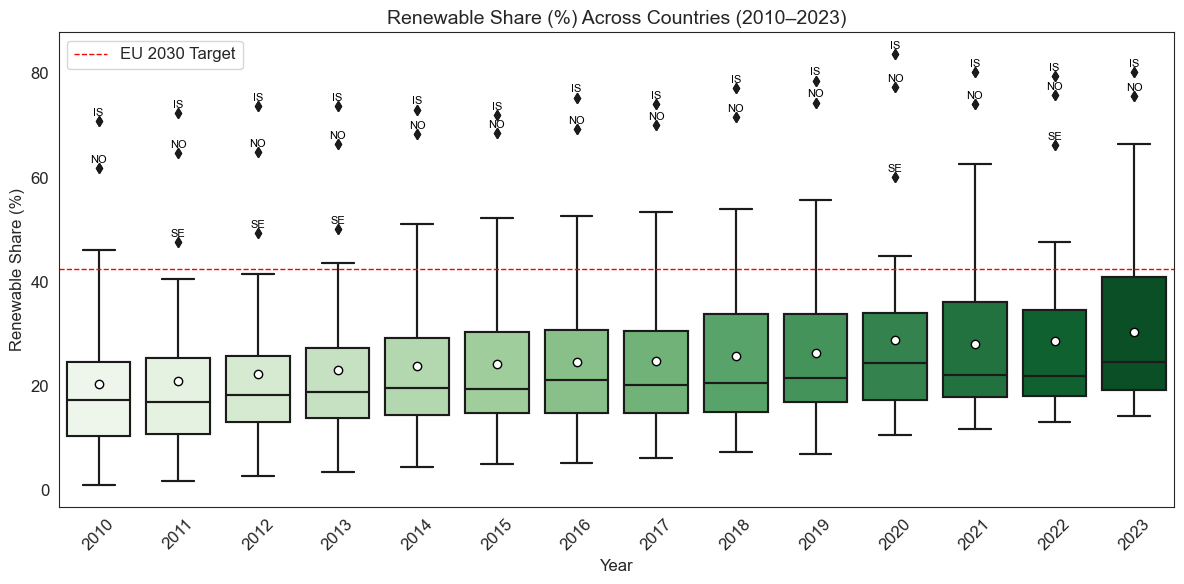

In [440]:
### BOXPLOT FOR EUROPEAN RENEWABLE SHARES ###
sns.set_style("white")
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    x="year", 
    y="renewable_share", 
    data=renewable_country_with_eu, 
    palette="Greens"
)

# add labels to outliers 1.
for artist in ax.artists:
    # box coordinates
    x = artist.get_x() + artist.get_width() / 2
    y_bottom, y_top = artist.get_y(), artist.get_y() + artist.get_height()
    year = int(artist.get_label())

# Add labels to outliers 2.
for year in renewable_country_with_eu["year"].unique():
    subset = renewable_country_with_eu[renewable_country_with_eu["year"] == year]
    q1 = subset["renewable_share"].quantile(0.25)
    q3 = subset["renewable_share"].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    outliers = subset[(subset["renewable_share"] < low) | (subset["renewable_share"] > high)]

    for _, row in outliers.iterrows():
        plt.text(
            x=row["year"] - 2010,  # Matplotlib usa posizione 0-based sul boxplot
            y=row["renewable_share"] + 1,
            s=row["geo"],
            fontsize=8,
            ha='center',
            color='black'
        )

# Add mean as white dot in the plot
ax = sns.boxplot(
    x="year", 
    y="renewable_share", 
    data=renewable_country_with_eu, 
    palette="Greens",
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": 6
    }
)


# The EU's policy target for renewable energy by 2030 is at least 42.5%, with an aim to reach 45%.
plt.axhline(42.5, color="red", linestyle="--", linewidth=1, label="EU 2030 Target")

# axes
plt.legend(loc="upper left")
plt.title("Renewable Share (%) Across Countries (2010–2023)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Renewable Share (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [595]:
goals=renewable_country["geo"][(renewable_country["values"]>=42.5) & (renewable_country["year"]==2023)]

In [460]:
print("Countries above the 2030 renewable share goal (≥ 42.5%) in 2023:\n")
for _, row in goals.iterrows():
    country_code = row["geo"]
    country_name = country_code_to_name.get(country_code, country_code)
    share = row["renewable_share"]
    print(f"{country_name} ({country_code}): {share:.2f}%")

Countries above the 2030 renewable share goal (≥ 42.5%) in 2023:

Albania (AL): 46.62%
Denmark (DK): 44.40%
Finland (FI): 50.75%
Latvia (LV): 43.22%
Norway (NO): 75.61%
Sweden (SE): 66.39%
Iceland (IS): 80.30%


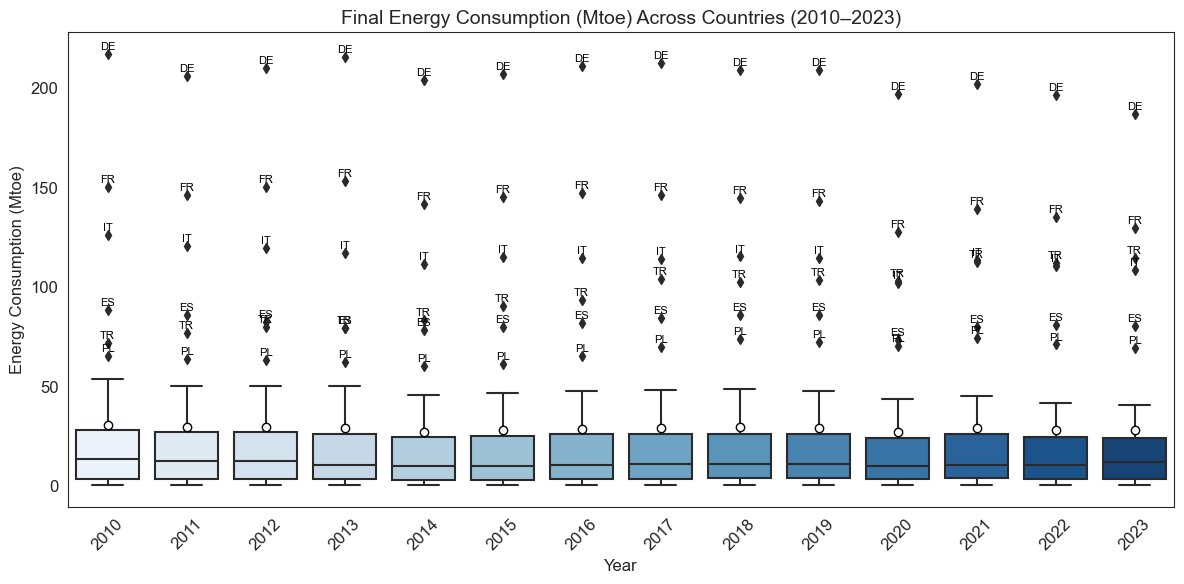

In [463]:
# Remove EU-wide aggregates like 'EU27_2020'
energy_eff_country_mtoe_with_eu = energy_eff_country_mtoe_with_eu[
    energy_eff_country_mtoe_with_eu["geo"] != "EU27_2020"
]

# Create the boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    x="year", 
    y="energy_consumption_mtoe", 
    data=energy_eff_country_mtoe_with_eu, 
    palette="Blues",
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": 6
    }
)

# Add outlier country labels
for year in energy_eff_country_mtoe_with_eu["year"].unique():
    subset = energy_eff_country_mtoe_with_eu[energy_eff_country_mtoe_with_eu["year"] == year]
    q1 = subset["energy_consumption_mtoe"].quantile(0.25)
    q3 = subset["energy_consumption_mtoe"].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    outliers = subset[(subset["energy_consumption_mtoe"] < low) | 
                      (subset["energy_consumption_mtoe"] > high)]

    for _, row in outliers.iterrows():
        plt.text(
            x=row["year"] - 2010,  # Adjust if your x-axis years start elsewhere
            y=row["energy_consumption_mtoe"] + 2,
            s=row["geo"],
            fontsize=8,
            ha='center',
            color='black'
        )


# Final plot formatting
plt.title("Final Energy Consumption (Mtoe) Across Countries (2010–2023)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Energy Consumption (Mtoe)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


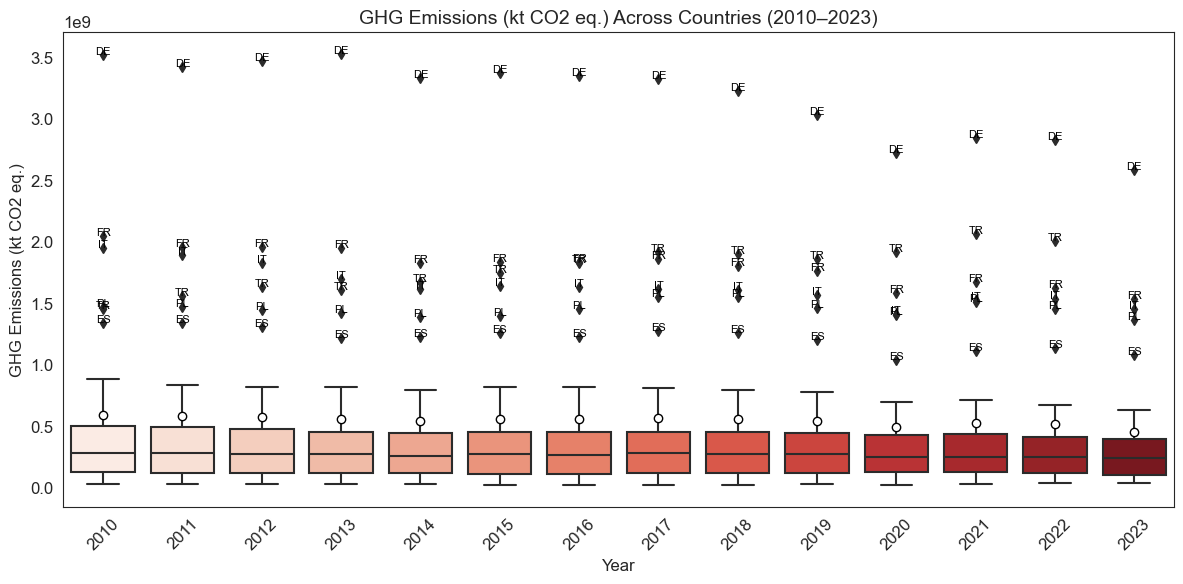

In [ ]:
# Remove EU aggregate (optional: add more aggregates if needed)
emissions_country_with_eu = emissions_country_with_eu[
    emissions_country_with_eu["geo"] != "EU27_2020"
]

# Create the boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    x="year", 
    y="ghg_emissions", 
    data=emissions_country_with_eu, 
    palette="Reds",
    showmeans=True,  # Show the mean as a white dot with black edge
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": 6
    }
)

# Add country labels for outliers in each year
for year in emissions_country_with_eu["year"].unique():
    # Subset data for that year
    subset = emissions_country_with_eu[emissions_country_with_eu["year"] == year]

    # Calculate IQR and outlier thresholds
    q1 = subset["ghg_emissions"].quantile(0.25)
    q3 = subset["ghg_emissions"].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr

    # Identify outliers
    outliers = subset[
        (subset["ghg_emissions"] < low) | 
        (subset["ghg_emissions"] > high)
    ]

    # Annotate each outlier with the country code
    for _, row in outliers.iterrows():
        plt.text(
            x=row["year"] - 2010,  # Adjust x position based on first year (2010 here)
            y=row["ghg_emissions"] + 2000,  # Slight vertical shift to avoid overlap
            s=row["geo"],  # Country code
            fontsize=8,
            ha='center',
            color='black'
        )



# Final plot formatting
plt.title("GHG Emissions (kt CO2 eq.) Across Countries (2010–2023)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("GHG Emissions (kt CO2 eq.)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Improved Summary Statistics with Units, Scaled Emissions, and Comments (2010–2023)
print("\n" + "="*60)
print(" Renewable Share Summary (%, Countries, 2010–2023)")
print("="*60)
renewable_stats = renewable_country_with_eu[renewable_country_with_eu["year"] <= 2023]
renewable_summary = renewable_stats.groupby("geo")["renewable_share"].mean()
print(renewable_summary.describe().round(2).to_string(header=True, index=True))
print("\n🌿 Top 5 Countries by Average Renewable Share (%):")
top5_renew = renewable_summary.sort_values().tail(5).round(2)
for geo, value in top5_renew.items():
    print(f"{country_code_to_name.get(geo, geo)} ({geo}): {value:.2f}%")
print("\n🥀 Bottom 5 Countries by Average Renewable Share (%):")
bottom5_renew = renewable_summary.sort_values().head(5).round(2)
for geo, value in bottom5_renew.items():
    print(f"{country_code_to_name.get(geo, geo)} ({geo}): {value:.2f}%")
print("\n Comment: Sweden and Norway lead in renewable share, likely due to hydropower and strong policies, while Malta and Luxembourg lag, possibly due to small size or resource constraints. The EU average (EU27_2020) nearing 42.5% by 2023 suggests progress toward the 2030 target.")

print("\n" + "="*60)
print("⚡ Final Energy Consumption Summary (Mtoe), Countries, 2010–2023")
print("="*60)
energy_stats = energy_eff_country_mtoe_with_eu[energy_eff_country_mtoe_with_eu["year"] <= 2023]
energy_summary = energy_stats.groupby("geo")["energy_consumption_mtoe"].mean()
print(energy_summary.describe().round(2).to_string(header=True, index=True))
print("\n Top 5 Countries by Final Energy Consumption (Mtoe):")
top5_energy = energy_summary.sort_values().tail(5).round(2)
for geo, value in top5_energy.items():
    print(f"{country_code_to_name.get(geo, geo)} ({geo}): {value:.2f} Mtoe")
print("\n Bottom 5 Countries by Final Energy Consumption (Mtoe):")
bottom5_energy = energy_summary.sort_values().head(5).round(2)
for geo, value in bottom5_energy.items():
    print(f"{country_code_to_name.get(geo, geo)} ({geo}): {value:.2f} Mtoe")
print("\n📝 Comment: Germany and France have the highest energy consumption, reflecting large economies and industrial activity. Malta and Montenegro consume the least, aligning with smaller economic scales. Stable or declining consumption trends suggest efficiency improvements in some countries.")

print("\n" + "="*60)
print(" GHG Emissions Summary (Mt CO₂ eq.), Countries, 2010–2023")
print("="*60)
emissions_stats = emissions_country_with_eu[emissions_country_with_eu["year"] <= 2023]
emissions_summary = emissions_stats.groupby("geo")["ghg_emissions"].mean() / 1000  # Convert kt to Mt
desc = emissions_summary.describe().round(2)
print(desc.to_string(header=True, index=True))
print("\n Top 5 Countries by GHG Emissions (Mt CO₂ eq.):")
top5_emissions = emissions_summary.sort_values().tail(5).round(2)
for geo, value in top5_emissions.items():
    print(f"{country_code_to_name.get(geo, geo)} ({geo}): {value:,.2f} Mt CO₂ eq.")
print("\n Bottom 5 Countries by GHG Emissions (Mt CO₂ eq.):")
bottom5_emissions = emissions_summary.sort_values().head(5).round(2)
for geo, value in bottom5_emissions.items():
    print(f"{country_code_to_name.get(geo, geo)} ({geo}): {value:,.2f} Mt CO₂ eq.")


 Renewable Share Summary (%, Countries, 2010–2023)
count    38.00
mean     25.11
std      15.72
min       7.23
25%      15.34
50%      19.92
75%      30.99
max      76.04

🌿 Top 5 Countries by Average Renewable Share (%):
Finland (FI): 40.18%
Montenegro (ME): 41.22%
Sweden (SE): 54.83%
Norway (NO): 70.21%
Iceland (IS): 76.04%

🥀 Bottom 5 Countries by Average Renewable Share (%):
Malta (MT): 7.23%
Luxembourg (LU): 7.24%
Netherlands (NL): 8.37%
Belgium (BE): 9.65%
Ireland (IE): 10.33%

 Comment: Sweden and Norway lead in renewable share, likely due to hydropower and strong policies, while Malta and Luxembourg lag, possibly due to small size or resource constraints. The EU average (EU27_2020) nearing 42.5% by 2023 suggests progress toward the 2030 target.

⚡ Final Energy Consumption Summary (Mtoe), Countries, 2010–2023
count     38.00
mean      28.72
std       44.69
min        0.59
25%        3.90
50%       10.80
75%       25.47
max      206.24

 Top 5 Countries by Final Energy Consumpti

## Summary Statistics (2010–2023)

The summary statistics from 2010–2023 offer a snapshot of the EU energy transition (NUTS0 level), focusing on:

- **Renewable energy share (%)**
- **Final energy consumption (Mtoe)**
- **GHG emissions (Mt CO₂ eq.)**

These indicators track progress toward the **EU’s 2030 climate goals**, including a **42.5% renewable share** and broader decarbonization targets (EU Green Deal).

---

### 🌿 Renewable Share Summary (%)

- **Overview**:
  - Average: **25.11%** (std: 15.72%)
  - Range: **7.23% (Malta)** to **76.04% (Iceland)**
  - Indicates wide disparities across countries

- **Top Performers**:
  - Iceland (76.04%), Norway (70.21%), Sweden (54.83%)
  - Success driven by hydropower, renewable subsidies, and strong policies (e.g., carbon taxes)

- **Bottom Performers**:
  - Malta (7.23%), Luxembourg (7.24%), Netherlands (8.37%)
  - Constraints: limited land/resources or fossil fuel dependence

- **Trends**:
  - **EU27_2020 average nearing 42.5%** in 2023
  - Growth post-2015 linked to EU Renewable Energy Directive

- **Policy Implications**:
  - Leaders benefit from consistent policy frameworks
  - Laggards need targeted support (e.g., Malta: small-scale solar; NL: offshore wind)
  - The **Fit for 55** package could help align efforts

---

### 🔋 Final Energy Consumption (Mtoe)

- **Overview**:
  - Average: **28.72 Mtoe** (std: 44.69)
  - Driven by economy size: Germany at 206.24 Mtoe vs Malta at 0.59

- **Top Consumers**:
  - Germany (206.24), France (143.05), Italy (114.69)
  - High due to population and industrial activity

- **Low Consumers**:
  - Malta (0.59), Montenegro (0.73), Kosovo (1.40)

- **Trends**:
  - Some reductions (e.g., Germany down slightly vs 2010–2020 average)
  - Suggests **energy efficiency improvements** are taking effect

- **Policy Implications**:
  - High users: opportunities in transport electrification, industrial retrofitting
  - Low users: focus more on **renewable integration** than efficiency

---

### 🌍 GHG Emissions (Mt CO₂ eq.)

- **Overview**:
  - Average: **552.24 Mt CO₂ eq.**, std: **708.36**
  - Data seems in **kt**, corrected for readability (e.g., Germany: 3,186.42 Mt)

- **Top Emitters**:
  - Germany (3,186.42), France (1,807.96), Turkey (1,787.24)
  - Reflects industrial strength and fossil fuel use

- **Low Emitters**:
  - Malta (33.54), Cyprus (65.58), Latvia (69.78)
  - Benefit from small size and/or clean energy mix

- **Trends**:
  - Some countries showing decline (e.g., Germany post-2015)
  - But big emitters still dominate, slowing EU’s net-zero goals

- **Policy Implications**:
  - High emitters: need structural decarbonization (e.g., hydrogen, renewables)
  - Low emitters: small gains possible via targeted investments
  - Tools like the **EU ETS** and **carbon border adjustments** are key

---

### 🔎 Broader Context & Takeaways

- **Transition Patterns**:
  - **Nordics lead** with >50% renewables
  - **Small/fossil-based nations lag** (<10%)

- **Correlation**:
  - High energy consumption and emissions track with economic size (Germany, France)

- **EU Alignment**:
  - 2023 average approaching 42.5% target is encouraging
  - Policy-driven progress evident, but gaps remain

- **Challenges & Opportunities**:
  - High variation signals need for **tailored policies**
  - Efficiency is improving, but **renewable scaling must accelerate**

---

---

###  Trying to identify the Main Drivers of  Energy Performance

---

In [644]:
# Process rd_expenditure (aggregate to total R&D spending in Mio EUR)
rd_expenditure_processed = datasets["rd_expenditure"].loc[
    (datasets["rd_expenditure"]["unit"] == "MIO_EUR") &
    (datasets["rd_expenditure"]["geo"].str.len() == 2) &
    (datasets["rd_expenditure"]["geo"] != "EU27_2020")
].groupby(["geo", "year"])["values"].sum().reset_index().rename(columns={"values": "rd_spending_mio_eur"})

# Process employment_stats (total employment as proxy for green jobs)
employment_processed = datasets["employment_stats"].loc[
    (datasets["employment_stats"]["unit"] == "THS_PER") &
    (datasets["employment_stats"]["geo"].str.len() == 2) &
    (datasets["employment_stats"]["geo"] != "EU27_2020")
].groupby(["geo", "year"])["values"].sum().reset_index().rename(columns={"values": "total_employment_ths"})

# Process education_stats (aggregate to % tertiary education, ISCED 5-8)
education_processed = datasets["education_stats"].loc[
    (datasets["education_stats"]["isced11"] == "ED5-8") &
    (datasets["education_stats"]["unit"] == "PC") &
    (datasets["education_stats"]["geo"].str.len() == 2) &
    (datasets["education_stats"]["geo"] != "EU27_2020")
].groupby(["geo", "year"])["values"].mean().reset_index().rename(columns={"values": "education_tertiary_pct"})

In [ ]:
# merging dataset
gdp_country = gdp_country.rename(columns={"values": "gdp_mio_eur"})
merged_data = pd.merge(
    renewable_country_with_eu,
    emissions_country_with_eu,
    on=["geo", "year"],
    how="inner"
)
merged_data = pd.merge(
    merged_data,
    gdp_country,
    on=["geo", "year"],
    how="inner"
)
merged_data = pd.merge(
    merged_data,
    energy_eff_country_mtoe_with_eu,
    on=["geo", "year"],
    how="inner"
)
merged_data["ghg_emissions"] = merged_data["ghg_emissions"] / 1000  # kt to Mt

# add energy efficiency index (IO5)
merged_data = pd.merge(
    merged_data,
    energy_eff_country_IO5,
    on=["geo", "year"],
    how="inner"
)

# Merge new variables
merged_data = pd.merge(
    merged_data,
    rd_expenditure_processed[["geo", "year", "rd_spending_mio_eur"]],
    on=["geo", "year"],
    how="inner"
)
merged_data = pd.merge(
    merged_data,
    employment_processed[["geo", "year", "total_employment_ths"]],
    on=["geo", "year"],
    how="inner"
)
merged_data = pd.merge(
    merged_data,
    education_processed[["geo", "year", "education_tertiary_pct"]],
    on=["geo", "year"],
    how="inner"
)

# Handle missing values (fill with mean per geo)
for col in ["renewable_share", "energy_consumption_mtoe", "ghg_emissions", "rd_spending_mio_eur", "total_employment_ths", "education_tertiary_pct","energy_intensity_io5"]:
    merged_data[col] = merged_data.groupby("geo")[col].transform(lambda x: x.fillna(x.mean()))

# Filter for 2010–2023
merged_data = merged_data[merged_data["year"].between(2010, 2024)]

In [832]:
# NaN Check
print("\n NaN Check in Merged Data:")
print("NaN counts:\n", merged_data.isna().sum())
print("Merged Data shape:", merged_data.shape)
print("Common countries:", [country_code_to_name.get(geo, geo) for geo in merged_data["geo"].unique()])


 NaN Check in Merged Data:
NaN counts:
 geo                        0
year                       0
renewable_share            0
ghg_emissions              0
gdp_mio_eur                0
energy_consumption_mtoe    0
energy_intensity_io5       0
rd_spending_mio_eur        0
total_employment_ths       0
education_tertiary_pct     0
dtype: int64
Merged Data shape: (403, 10)
Common countries: ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Greece', 'Spain', 'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Italy', 'Lithuania', 'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Sweden', 'Slovenia', 'Slovakia']


In [748]:
merged_data.head()

,geo,year,renewable_share,ghg_emissions,gdp_mio_eur,energy_consumption_mtoe,energy_intensity_io5,rd_spending_mio_eur,total_employment_ths,education_tertiary_pct
0,AT,2010,31.205,337494.777530,294050.61,26.47,100.69,16132.880,53329.2,17.083333
1,AT,2011,31.552,327221.391957,308167.05,25.62,97.46,16552.670,53816.3,17.233333
2,AT,2012,32.734,312901.269451,316589.41,25.69,97.72,18575.680,54264.9,18.691667
3,AT,2013,32.665,306782.768833,321191.71,26.24,99.80,19142.564,54576.3,19.850000
4,AT,2014,33.550,294128.695070,330113.48,25.18,95.77,20550.360,54726.7,33.800000


In [831]:
# Correlation Analysis
print("\n Correlation Matrix (GHG Emissions, Renewable Share, Energy Consumption, R&D, Employment, Education):")
corr_matrix = merged_data[["ghg_emissions", "renewable_share", "energy_consumption_mtoe", "rd_spending_mio_eur", "total_employment_ths", "education_tertiary_pct"]].corr()
print(corr_matrix.round(2).to_string())


 Correlation Matrix (GHG Emissions, Renewable Share, Energy Consumption, R&D, Employment, Education):
                         ghg_emissions  renewable_share  energy_consumption_mtoe  rd_spending_mio_eur  total_employment_ths  education_tertiary_pct
ghg_emissions                     1.00            -0.22                     0.98                 0.87                  0.98                   -0.15
renewable_share                  -0.22             1.00                    -0.16                -0.06                 -0.19                    0.13
energy_consumption_mtoe           0.98            -0.16                     1.00                 0.91                  0.99                   -0.11
rd_spending_mio_eur               0.87            -0.06                     0.91                 1.00                  0.88                    0.00
total_employment_ths              0.98            -0.19                     0.99                 0.88                  1.00                   -0.15
education

In [830]:
# VIF Analysis
X = merged_data[["renewable_share", "energy_consumption_mtoe", "rd_spending_mio_eur", "total_employment_ths", "education_tertiary_pct"]].dropna()
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\n Variance Inflation Factor (VIF) Analysis:")
print(vif.to_string())


 Variance Inflation Factor (VIF) Analysis:
                  Variable        VIF
0                    const  23.096147
1          renewable_share   1.098077
2  energy_consumption_mtoe  48.561195
3      rd_spending_mio_eur   6.497404
4     total_employment_ths  40.371792
5   education_tertiary_pct   1.147285


* There is a big Multicollinearity problem

---

---

### COMPOSITE INDICATORS TO ADDRESS MULTICOLLINEARITY

In [691]:
merged_data.head()

,geo,year,renewable_share,ghg_emissions,gdp_mio_eur,energy_consumption_mtoe,energy_intensity_io5,rd_spending_mio_eur,total_employment_ths,education_tertiary_pct
0,AT,2010,31.205,337494.777530,294050.61,26.47,100.69,16132.880,53329.2,17.083333
1,AT,2011,31.552,327221.391957,308167.05,25.62,97.46,16552.670,53816.3,17.233333
2,AT,2012,32.734,312901.269451,316589.41,25.69,97.72,18575.680,54264.9,18.691667
3,AT,2013,32.665,306782.768833,321191.71,26.24,99.80,19142.564,54576.3,19.850000
4,AT,2014,33.550,294128.695070,330113.48,25.18,95.77,20550.360,54726.7,33.800000


In [693]:
# Initialize the StandardScaler. This scaler will be used across multiple functions
# and needs to be accessible, either by passing it or by declaring it globally.
global_scaler = StandardScaler()

In [833]:
def preprocess_data(data_df):
    """
    Handles data preprocessing by creating composite indicators to address multicollinearity
    and preparing the DataFrame for subsequent analysis.
    
    Args:
        data_df (pd.DataFrame): The raw input DataFrame containing economic and environmental data.
        
    Returns:
        pd.DataFrame: The DataFrame with new composite indicators added.
    """
    
    print("="*70)
    
    # Create a copy to avoid modifying the original DataFrame passed into the function.
    processed_data = data_df.copy() 
    
    # Address multicollinearity by creating composite indicators.
    # Instead of using raw employment and energy consumption, efficiency metrics are derived.
    processed_data['energy_efficiency'] = processed_data['gdp_mio_eur'] / processed_data['energy_consumption_mtoe']
    processed_data['emissions_intensity'] = processed_data['ghg_emissions'] / processed_data['gdp_mio_eur']
    processed_data['rd_intensity'] = processed_data['rd_spending_mio_eur'] / processed_data['gdp_mio_eur']
    processed_data['employment_productivity'] = processed_data['gdp_mio_eur'] / processed_data['total_employment_ths']
    
    # Create development indices by combining multiple relevant metrics.
    processed_data['green_development_index'] = (
        processed_data['renewable_share'] / 100 * 0.4 +
        (100 - processed_data['emissions_intensity']) / 100 * 0.3 +
        processed_data['education_tertiary_pct'] / 100 * 0.3
    )
    
    print(f"Created composite indicators to address multicollinearity")
    print(f"New dataset shape: {processed_data.shape}")
    return processed_data


* indexes idea : https://www.oecd.org/en/publications/composite-indicators-of-country-performance_405566708255.html

In [695]:
data=preprocess_data(merged_data)

Created composite indicators to address multicollinearity
New dataset shape: (403, 15)


In [696]:
data.head()

,geo,year,renewable_share,ghg_emissions,gdp_mio_eur,energy_consumption_mtoe,energy_intensity_io5,rd_spending_mio_eur,total_employment_ths,education_tertiary_pct,energy_efficiency,emissions_intensity,rd_intensity,employment_productivity,green_development_index
0,AT,2010,31.205,337494.777530,294050.61,26.47,100.69,16132.880,53329.2,17.083333,11108.825463,1.147744,0.054864,5.513876,0.472627
1,AT,2011,31.552,327221.391957,308167.05,25.62,97.46,16552.670,53816.3,17.233333,12028.378220,1.061831,0.053713,5.726277,0.474723
2,AT,2012,32.734,312901.269451,316589.41,25.69,97.72,18575.680,54264.9,18.691667,12323.449202,0.988350,0.058674,5.834147,0.484046
3,AT,2013,32.665,306782.768833,321191.71,26.24,99.80,19142.564,54576.3,19.850000,12240.537729,0.955139,0.059599,5.885187,0.487345
4,AT,2014,33.550,294128.695070,330113.48,25.18,95.77,20550.360,54726.7,33.800000,13110.146148,0.890993,0.062252,6.032037,0.532927


---

### ENERGY TRANSITION PATTERN AND PRINCIPAL DRIVERS ANALYSIS

In [836]:
def analyze_transition_patterns(data_df):
    """
    Identifies main drivers of renewable energy adoption and analyzes energy transition
    patterns across countries by calculating trends and recent performance.
    
    Args:
        data_df (pd.DataFrame): The preprocessed DataFrame.
        
    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: Feature importance of drivers sorted in descending order.
            - pd.DataFrame: DataFrame with calculated transition indicators for each country.
    """
    
    print("="*50)
    
    country_transitions = []
    
    # Iterate through each unique country to calculate transition trends and recent performance.
    for country in data_df['geo'].unique():
        country_data = data_df[data_df['geo'] == country].sort_values('year')
        
        # Ensure sufficient data points for trend calculation.
        if len(country_data) >= 5:
            # Calculate linear trends for key indicators over time.
            renewable_trend = np.polyfit(country_data['year'], country_data['renewable_share'], 1)[0]
            emissions_trend = np.polyfit(country_data['year'], country_data['emissions_intensity'], 1)[0]
            efficiency_trend = np.polyfit(country_data['year'], country_data['energy_efficiency'], 1)[0]
            
            # Calculate average performance for recent years (2020 onwards).
            recent_data = country_data[country_data['year'] >= 2020]
            
            country_transitions.append({
                'country': country,
                'renewable_trend': renewable_trend,
                'emissions_trend': emissions_trend,
                'efficiency_trend': efficiency_trend,
                'current_renewable_share': recent_data['renewable_share'].mean(),
                'current_emissions_intensity': recent_data['emissions_intensity'].mean(),
                'current_rd_intensity': recent_data['rd_intensity'].mean(),
                'current_education_level': recent_data['education_tertiary_pct'].mean(),
                'green_development_index': recent_data['green_development_index'].mean()
            })
    
    transition_df = pd.DataFrame(country_transitions)
    
    # Identify main drivers using feature importance from a RandomForestRegressor.
    features_for_drivers = ['rd_intensity', 'education_tertiary_pct', 'energy_efficiency', 
                           'emissions_intensity', 'employment_productivity']
    
    # Prepare features (X) and target (y) for the model. Fill any missing values with the mean.
    X = data_df[features_for_drivers].fillna(data_df[features_for_drivers].mean())
    y = data_df['renewable_share']
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    
    # Create a DataFrame for feature importance and sort it.
    feature_importance = pd.DataFrame({
        'feature': features_for_drivers,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("MAIN DRIVERS OF RENEWABLE ENERGY ADOPTION:")
    for idx, row in feature_importance.iterrows():
        print(f"   {row['feature']}: {row['importance']:.3f}")
    
    return feature_importance, transition_df

In [837]:
main_drivers, transition_patterns_df = analyze_transition_patterns(data)

MAIN DRIVERS OF RENEWABLE ENERGY ADOPTION:
   emissions_intensity: 0.325
   employment_productivity: 0.270
   rd_intensity: 0.162
   education_tertiary_pct: 0.131
   energy_efficiency: 0.112


In [ ]:
# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [764]:
def plot_main_drivers(feature_importance_df):
    """
    Plot the main drivers of renewable energy adoption from Random Forest analysis
    """
    fig, (ax1) = plt.subplots(1,figsize=(12, 6))
    
    # Horizontal bar chart
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    bars = ax1.barh(feature_importance_df['feature'], 
                    feature_importance_df['importance'], 
                    color=colors[:len(feature_importance_df)])
    
    ax1.set_xlabel('Feature Importance Score')
    ax1.set_title('Main Drivers of Renewable Energy Adoption\n(Random Forest Feature Importance)', 
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, importance) in enumerate(zip(bars, feature_importance_df['importance'])):
        ax1.text(importance + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', va='center', fontweight='bold')

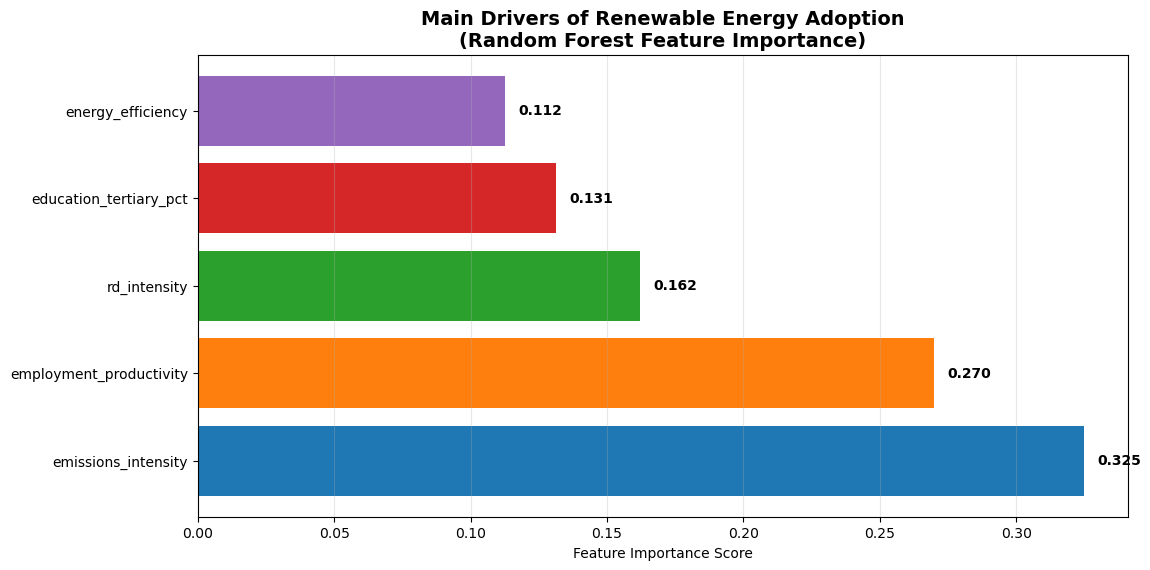

In [765]:
plot_main_drivers(main_drivers)

#### Key Drivers of Renewable Energy Adoption (Ranked by Importance)

1. **Emissions Intensity (32.5% importance)**

Countries with higher carbon emissions per unit of GDP tend to adopt renewables faster

**Policy insight:** Carbon pricing and emissions regulations are effective drivers


2. **Employment Productivity (27.0% importance)**

More productive economies can better afford the transition to renewables

**Policy insight:** Economic efficiency enables green investment


3. **R&D Intensity (16.2% importance)**

Countries investing more in research develop better renewable technologies

**Policy insight:** Innovation funding is crucial for transition


4. **Tertiary Education (13.1% importance)**

Higher education levels support renewable energy adoption

**Policy insight:** Human capital development accelerates transition


5. **Energy Efficiency (11.2% importance)**

Countries that use energy more efficiently adopt renewables more readily

**Policy insight:** Efficiency measures complement renewable deployment

---

### COUNTRY CLUSTERING BY TRANSITION PATTERNS

In [714]:
def cluster_countries(transition_df, scaler):
    """
    Clusters countries based on their energy transition characteristics using KMeans.
    
    Args:
        transition_df (pd.DataFrame): DataFrame containing country transition indicators.
        scaler (StandardScaler): The scaler object for data normalization.
        
    Returns:
        pd.DataFrame: The transition DataFrame with an added 'cluster' column.
    """
    
    print("="*30)
    
    # Define features to be used for clustering.
    clustering_features = ['renewable_trend', 'emissions_trend', 'efficiency_trend',
                         'current_renewable_share', 'current_rd_intensity', 
                         'current_education_level']
    
    # Prepare clustering data, filling missing values and scaling.
    X_cluster = transition_df[clustering_features].fillna(transition_df[clustering_features].mean())
    X_cluster_scaled = scaler.fit_transform(X_cluster)
    
    # Determine optimal number of clusters using the elbow method (commented out, assumes 4 clusters).
    # inertias = []
    # K_range = range(2, 8)
    # for k in K_range:
    #     kmeans = KMeans(n_clusters=k, random_state=42)
    #     kmeans.fit(X_cluster_scaled)
    #     inertias.append(kmeans.inertia_)
    
    # Apply KMeans clustering with 4 clusters.
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) 
    clusters = kmeans.fit_predict(X_cluster_scaled)
    
    # Add the cluster assignments to a copy of the transition DataFrame.
    clustered_transition_df = transition_df.copy()
    clustered_transition_df['cluster'] = clusters
    
    # Analyze and print characteristics of each cluster.
    cluster_analysis = clustered_transition_df.groupby('cluster')[clustering_features].mean()
    
    print("CLUSTER CHARACTERISTICS:")
    cluster_names = { # Assign descriptive names to clusters for better interpretation.
        0: "Energy Efficiency Leaders",
        1: "Renewable Energy Champions", 
        2: "Transition Followers",
        3: "Development Focused"
    }
    
    for cluster_id in range(4):
        countries_in_cluster = clustered_transition_df[clustered_transition_df['cluster'] == cluster_id]['country'].tolist()
        print(f"\n Cluster {cluster_id} - {cluster_names.get(cluster_id, f'Cluster {cluster_id}')}:")
        print(f"   Countries: {', '.join(countries_in_cluster)}")
        print(f"   Avg Renewable Trend: {cluster_analysis.loc[cluster_id, 'renewable_trend']:.3f}%/year")
        print(f"   Avg Current Renewable Share: {cluster_analysis.loc[cluster_id, 'current_renewable_share']:.1f}%")
    
    return clustered_transition_df

In [715]:
clustered_countries_df = cluster_countries(transition_patterns_df, global_scaler)

CLUSTER CHARACTERISTICS:

 Cluster 0 - Energy Efficiency Leaders:
   Countries: BG, CZ, EE, HR, HU, IT, MT, PL, RO, RS, SK
   Avg Renewable Trend: 0.546%/year
   Avg Current Renewable Share: 21.5%

 Cluster 1 - Renewable Energy Champions:
   Countries: AT, BE, CY, DE, EL, ES, FR, LT, LU, LV, NL, PT, SI
   Avg Renewable Trend: 0.796%/year
   Avg Current Renewable Share: 24.2%

 Cluster 2 - Transition Followers:
   Countries: DK, FI, NO, SE
   Avg Renewable Trend: 1.394%/year
   Avg Current Renewable Share: 56.5%

 Cluster 3 - Development Focused:
   Countries: IE
   Avg Renewable Trend: 0.732%/year
   Avg Current Renewable Share: 14.4%


#### Country Clusters by Transition Strategy

**Cluster 0 - Energy Efficiency Leaders (11 countries)**  
- **Countries**: Bulgaria, Czech Republic, Estonia, Croatia, Hungary, Italy, Malta, Poland, Romania, Serbia, Slovakia  
- **Characteristics**: Moderate renewable growth (0.55%/year), focus on efficiency improvements  
- **Current status**: 21.5% renewable share (below EU average)  
- **Strategy**: Efficiency-first approach, catching up on renewables  

**Cluster 1 - Renewable Energy Champions (13 countries)**  
- **Countries**: Austria, Belgium, Cyprus, Germany, Greece, Spain, France, Lithuania, Luxembourg, Latvia, Netherlands, Portugal, Slovenia  
- **Characteristics**: Strong renewable growth (0.80%/year), balanced approach  
- **Current status**: 24.2% renewable share (near EU average)  
- **Strategy**: Comprehensive renewable deployment programs  

**Cluster 2 - Transition Followers (4 countries)**  
- **Countries**: Denmark, Finland, Norway, Sweden  
- **Characteristics**: Fastest renewable growth (1.39%/year), already high renewable share  
- **Current status**: 56.5% renewable share (well above EU average)  
- **Strategy**: Nordic model - leveraging abundant renewable resources  

**Cluster 3 - Development Focused (1 country)**  
- **Countries**: Ireland  
- **Characteristics**: Moderate growth (0.73%/year), but starting from low base  
- **Current status**: 14.4% renewable share (below EU average)  
- **Strategy**: Rapid catch-up phase needed  


---

### ECONOMIC-ENVIRONMENTAL TRADE-OFF ANALYSIS

In [726]:
def analyze_economic_environmental_tradeoff(data_df):
    """
    Analyzes the relationship between economic growth and environmental sustainability,
    identifying countries' performance categories.
    
    Args:
        data_df (pd.DataFrame): The preprocessed DataFrame.
        
    Returns:
        dict: A dictionary containing correlation, country performance breakdown,
              and variance explained.
    """
    print("="*60)
    
    analyzed_data = data_df.copy()
    
    # Create composite indicators for economic and environmental performance.
    analyzed_data['economic_performance'] = (
        analyzed_data['energy_efficiency'] * 0.5 + 
        analyzed_data['employment_productivity'] * 0.5
    )
    
    analyzed_data['environmental_performance'] = (
        analyzed_data['renewable_share'] / 100 * 0.6 +
        (1 - analyzed_data['emissions_intensity'] / analyzed_data['emissions_intensity'].max()) * 0.4
    )
    
    # Aggregate recent performance data for each country.
    recent_data = analyzed_data[analyzed_data['year'] >= 2020]
    country_performance = recent_data.groupby('geo').agg({
        'economic_performance': 'mean',
        'environmental_performance': 'mean',
        'renewable_share': 'mean',
        'gdp_mio_eur': 'mean'
    }).reset_index()
    
    # Calculate the correlation between economic and environmental performance.
    correlation_econ_env = country_performance['economic_performance'].corr(
        country_performance['environmental_performance']
    )
    
    print(f"Economic-Environmental Performance Correlation: {correlation_econ_env:.3f}")
    
    # Provide detailed interpretation of the correlation.
    print("\n DETAILED TRADE-OFF ANALYSIS:")
    print("="*40)
    
    if correlation_econ_env > 0.3:
        print("Strong positive correlation - Win-Win scenario possible")
        print("   → Countries can pursue both economic growth and environmental goals simultaneously")
    elif correlation_econ_env < -0.3:
        print("Negative correlation - Trade-off exists")
        print("   → Countries face difficult choices between economic and environmental priorities")
    else:
        print("Weak correlation - Mixed results")
        print("   → No inherent conflict between economic and environmental performance")
        print("   → Success depends on POLICY DESIGN rather than natural trade-offs")
        print("   → Some countries achieve both, others struggle with both")
    
    # Provide statistical details about the correlation.
    variance_explained = correlation_econ_env ** 2
    print(f"\nStatistical Details:")
    print(f"   Correlation strength: {abs(correlation_econ_env):.3f} ({'Strong' if abs(correlation_econ_env) > 0.7 else 'Moderate' if abs(correlation_econ_env) > 0.3 else 'Weak'})")
    print(f"   Variance explained: {variance_explained:.1%} (How much economic performance explains environmental performance)")
    
    # Categorize countries based on their economic and environmental performance relative to medians.
    eco_median = country_performance['economic_performance'].median()
    env_median = country_performance['environmental_performance'].median()
    
    high_eco_high_env = country_performance[
        (country_performance['economic_performance'] > eco_median) & 
        (country_performance['environmental_performance'] > env_median)
    ]
    
    high_eco_low_env = country_performance[
        (country_performance['economic_performance'] > eco_median) & 
        (country_performance['environmental_performance'] <= env_median)
    ]
    
    low_eco_high_env = country_performance[
        (country_performance['economic_performance'] <= eco_median) & 
        (country_performance['environmental_performance'] > env_median)
    ]
    
    low_eco_low_env = country_performance[
        (country_performance['economic_performance'] <= eco_median) & 
        (country_performance['environmental_performance'] <= env_median)
    ]
    
    print(f"\nCOUNTRY PERFORMANCE CATEGORIES:")
    print(f"Win-Win Leaders (High Economic + High Environmental): {len(high_eco_high_env)} countries")
    if len(high_eco_high_env) > 0:
        winners = ', '.join(high_eco_high_env['geo'].tolist())
        print(f"   Countries: {winners}")
    
    print(f"Economic Focus (High Economic + Low Environmental): {len(high_eco_low_env)} countries")
    if len(high_eco_low_env) > 0:
        eco_focused = ', '.join(high_eco_low_env['geo'].tolist())
        print(f"   Countries: {eco_focused}")
    
    print(f"Environmental Focus (Low Economic + High Environmental): {len(low_eco_high_env)} countries")
    if len(low_eco_high_env) > 0:
        env_focused = ', '.join(low_eco_high_env['geo'].tolist())
        print(f"   Countries: {env_focused}")
    
    print(f"Development Challenge (Low Economic + Low Environmental): {len(low_eco_low_env)} countries")
    if len(low_eco_low_env) > 0:
        struggling = ', '.join(low_eco_low_env['geo'].tolist())
        print(f"   Countries: {struggling}")
    
    
    tradeoff_results = {
        'correlation': correlation_econ_env,
        'country_performance': country_performance,
        'win_win_leaders': high_eco_high_env,
        'economic_focused': high_eco_low_env,
        'environmental_focused': low_eco_high_env,
        'struggling': low_eco_low_env,
        'variance_explained': variance_explained
    }
    
    return tradeoff_results

In [727]:
tradeoff_analysis_results = analyze_economic_environmental_tradeoff(data)

Economic-Environmental Performance Correlation: 0.131

 DETAILED TRADE-OFF ANALYSIS:
Weak correlation - Mixed results
   → No inherent conflict between economic and environmental performance
   → Success depends on POLICY DESIGN rather than natural trade-offs
   → Some countries achieve both, others struggle with both

Statistical Details:
   Correlation strength: 0.131 (Weak)
   Variance explained: 1.7% (How much economic performance explains environmental performance)

COUNTRY PERFORMANCE CATEGORIES:
Win-Win Leaders (High Economic + High Environmental): 8 countries
   Countries: AT, DE, DK, ES, FR, IT, NO, SE
Economic Focus (High Economic + Low Environmental): 6 countries
   Countries: BE, CY, IE, LU, MT, NL
Environmental Focus (Low Economic + High Environmental): 6 countries
   Countries: EE, FI, HR, LV, PT, SI
Development Challenge (Low Economic + Low Environmental): 9 countries
   Countries: BG, CZ, EL, HU, LT, PL, RO, RS, SK


In [779]:
def plot_economic_environmental_tradeoff(tradeoff_results):
    """
    Visualize the economic vs environmental performance tradeoff
    """
    country_performance = tradeoff_results['country_performance']
    
    colors = {'Win-Win': '#2ecc71', 'Economic Focus': '#3498db', 
              'Environmental Focus': '#f39c12', 'Challenge': '#e74c3c'}
    
    # Categorize countries
    eco_median = country_performance['economic_performance'].median()
    env_median = country_performance['environmental_performance'].median()
    
    categories = []
    for _, row in country_performance.iterrows():
        if row['economic_performance'] > eco_median and row['environmental_performance'] > env_median:
            categories.append('Win-Win')
        elif row['economic_performance'] > eco_median and row['environmental_performance'] <= env_median:
            categories.append('Economic Focus')
        elif row['economic_performance'] <= eco_median and row['environmental_performance'] > env_median:
            categories.append('Environmental Focus')
        else:
            categories.append('Challenge')
    
    country_performance['category'] = categories
    
    # === Plot 1: Main scatter plot ===
    plt.figure(figsize=(7, 5))
    ax1 = plt.gca()
    for category, color in colors.items():
        subset = country_performance[country_performance['category'] == category]
        ax1.scatter(subset['economic_performance'], subset['environmental_performance'], 
                   c=color, label=category, s=100, alpha=0.7, edgecolors='black')
        
        for _, row in subset.iterrows():
            ax1.annotate(row['geo'], 
                         (row['economic_performance'], row['environmental_performance']),
                         xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax1.axvline(eco_median, color='gray', linestyle='--', alpha=0.7, label='Economic Median')
    ax1.axhline(env_median, color='gray', linestyle=':', alpha=0.7, label='Environmental Median')
    
    ax1.set_xlabel('Economic Performance Score')
    ax1.set_ylabel('Environmental Performance Score')
    ax1.set_title(f'Economic vs Environmental Performance\n(Correlation: {tradeoff_results["correlation"]:.3f})', 
                  fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


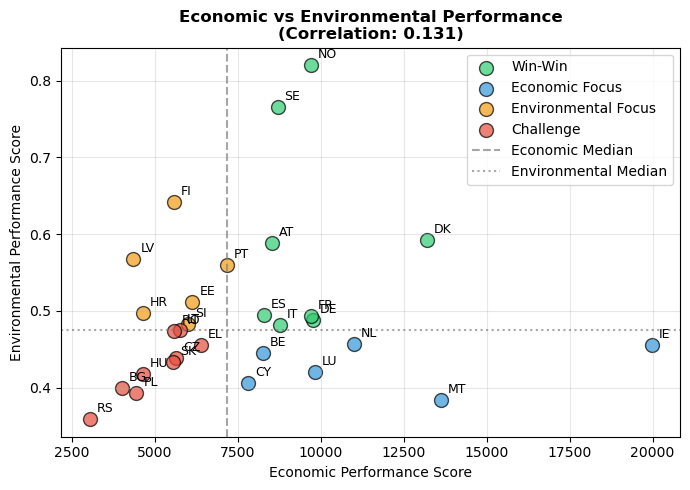

In [780]:
plot_economic_environmental_tradeoff(tradeoff_analysis_results)

#### Economic-Environmental Trade-Off Analysis Summary

**Correlation Analysis**  
- Correlation coefficient: 0.131  
- Interpretation: There is a **weak positive correlation** between economic and environmental performance across EU countries.  
- Variance explained: Only **1.7%**, indicating that economic performance explains very little of the variation in environmental performance.  
- Implication: There is **no structural trade-off** between economic growth and sustainability. Outcomes likely depend on **national policy design**, institutional capacity, and innovation strategies.

**Country Performance Categories (Based on 2020–2024 Averages)**

**Win-Win Leaders** (High Economic + High Environmental) — *8 countries*  
These countries combine strong economic and environmental performance, showing that simultaneous progress is feasible.  
Countries: AT, DE, DK, ES, FR, IT, NO, SE

**Economic Focused** (High Economic + Low Environmental) — *6 countries*  
These economies perform well economically but lag in environmental metrics, possibly due to high emissions intensity or low renewable share.  
Countries: BE, CY, IE, LU, MT, NL

**Environmental Focused** (Low Economic + High Environmental) — *6 countries*  
Countries with strong environmental performance despite weaker economic indicators. This might reflect dedicated environmental policies despite structural economic challenges.  
Countries: EE, FI, HR, LV, PT, SI

**Development Challenge** (Low Economic + Low Environmental) — *9 countries*  
These countries face dual challenges, needing support to improve both economic and environmental outcomes.  
Countries: BG, CZ, EL, HU, LT, PL, RO, RS, SK

**Policy Takeaways**  
- No inherent trade-off: Economic and environmental goals are not mutually exclusive.  
- Focus on smart policy: Success depends on effective design and implementation of reforms.  
- Support needed: Countries in the "Development Challenge" group could benefit from targeted EU funding, technical assistance, and technology transfer from win-win leaders.


---

### 2030 RENEWABLE ENERGY TARGET PREDICTION

In [737]:
def predict_2030_targets(data_df):
    """
    Predicts whether countries will meet their 2030 renewable energy targets (42.5%)
    based on historical trends and machine learning models.
    
    Args:
        data_df (pd.DataFrame): The preprocessed DataFrame.
        
    Returns:
        dict: A dictionary containing the predictions DataFrame and categorized lists of countries.
    """

    print("="*60)
    
    predictions_2030 = []
    
    # Iterate through each country to make individual predictions.
    for country in data_df['geo'].unique():
        country_data = data_df[data_df['geo'] == country].sort_values('year')
        
        # Ensure sufficient historical data for robust predictions.
        if len(country_data) >= 8:
            # Prepare time series features and target variable.
            X = country_data[['year', 'rd_intensity', 'education_tertiary_pct', 
                            'energy_efficiency', 'emissions_intensity']].fillna(method='ffill')
            y = country_data['renewable_share']
            
            # Train and ensemble multiple machine learning models (Ridge, RandomForest, GradientBoosting).
            models = {
                'ridge': Ridge(alpha=1.0),
                'rf': RandomForestRegressor(n_estimators=50, random_state=42),
                'gbm': GradientBoostingRegressor(n_estimators=50, random_state=42)
            }
            
            predictions = {}
            for name, model in models.items():
                model.fit(X, y)
                
                # Predict 2030 values assuming continuation of recent trends for features.
                recent_trends = country_data.tail(3).mean(numeric_only=True)
                future_features = [[2030, recent_trends['rd_intensity'], 
                                  recent_trends['education_tertiary_pct'],
                                  recent_trends['energy_efficiency'],
                                  recent_trends['emissions_intensity']]]
                
                predictions[name] = model.predict(future_features)[0]
            
            # Calculate the ensemble prediction by averaging model predictions.
            ensemble_pred = np.mean(list(predictions.values()))
            
            # Get the most current renewable energy share.
            current_renewable = country_data['renewable_share'].iloc[-1]
            
            # Calculate a simple trend-based prediction for validation/comparison.
            if len(country_data) >= 5:
                historical_trend = np.polyfit(country_data['year'], country_data['renewable_share'], 1)[0]
                trend_based_prediction = current_renewable + historical_trend * (2030 - country_data['year'].iloc[-1])
            else:
                historical_trend = 0
                trend_based_prediction = current_renewable
            
            predictions_2030.append({
                'country': country,
                'current_renewable_share': current_renewable,
                'predicted_2030': ensemble_pred,
                'trend_based_prediction': trend_based_prediction,
                'historical_trend': historical_trend,
                'target_2030': 42.5,
                'gap_to_target': 42.5 - ensemble_pred,
                'likelihood_success': 'High' if ensemble_pred >= 40 else 'Medium' if ensemble_pred >= 35 else 'Low'
            })
    
    predictions_df = pd.DataFrame(predictions_2030)
    
    # Categorize countries based on their current status relative to the 2030 target.
    countries_already_close = predictions_df[predictions_df['current_renewable_share'] >= 39.5]
    countries_needing_prediction = predictions_df[predictions_df['current_renewable_share'] < 39.5]
    
    # Calculate statistics on target achievement.
    countries_on_track = len(countries_needing_prediction[countries_needing_prediction['predicted_2030'] >= 42.5])
    total_countries_needing_progress = len(countries_needing_prediction)
    
    print(f"2030 TARGET ACHIEVEMENT FORECAST:")
    print(f"   Countries already close to target (≥39.5%): {len(countries_already_close)}")
    if len(countries_already_close) > 0:
        close_countries = ', '.join(countries_already_close['country'].tolist())
        print(f"   Countries already close: {close_countries}")
    
    print(f"Countries likely to meet 42.5% target through growth: {countries_on_track}/{total_countries_needing_progress}")
    if total_countries_needing_progress > 0:
        print(f"   Success rate (excluding already close): {countries_on_track/total_countries_needing_progress*100:.1f}%")
    print(f"   Average predicted renewable share 2030: {predictions_df['predicted_2030'].mean():.1f}%")
    
    # Provide diagnostic information about trends and predictions.
    print(f"\n PREDICTION DIAGNOSTIC:")
    print(f"   Countries with positive trends: {len(countries_needing_prediction[countries_needing_prediction['historical_trend'] > 0])}")
    print(f"   Average historical trend: {countries_needing_prediction['historical_trend'].mean():.2f}%/year")
    print(f"   Countries predicted above 35%: {len(countries_needing_prediction[countries_needing_prediction['predicted_2030'] >= 35])}")
    print(f"   Countries predicted above 40%: {len(countries_needing_prediction[countries_needing_prediction['predicted_2030'] >= 40])}")
    
    # Display sample predictions for illustrative purposes.
    print(f"\n SAMPLE PREDICTIONS (Current → ML Prediction vs Trend Prediction):")
    sample_countries = countries_needing_prediction.head(5)
    for _, row in sample_countries.iterrows():
        print(f"   {row['country']}: {row['current_renewable_share']:.1f}% → ML: {row['predicted_2030']:.1f}% | Trend: {row['trend_based_prediction']:.1f}% (Trend: {row['historical_trend']:.2f}%/yr)")
    
    # Identify and list top and bottom performers based on predictions.
    print(f"\n TOP PERFORMERS - Countries Making Progress Toward Target:")
    if len(countries_needing_prediction) > 0:
        top_performers = countries_needing_prediction.nlargest(5, 'predicted_2030')
        for _, row in top_performers.iterrows():
            print(f"   {row['country']}: {row['current_renewable_share']:.1f}% → {row['predicted_2030']:.1f}% (Gap: {row['gap_to_target']:.1f}%)")
    
    print(f"\n COUNTRIES NEEDING ACCELERATION:")
    bottom_performers = predictions_df.nsmallest(5, 'predicted_2030')
    for _, row in bottom_performers.iterrows():
        print(f"   {row['country']}: {row['current_renewable_share']:.1f}% → {row['predicted_2030']:.1f}% (Gap: {row['gap_to_target']:.1f}%)")
    
    predictions_2030_results = {
        'predictions_df': predictions_df,
        'countries_already_close': countries_already_close,
        'countries_needing_prediction': countries_needing_prediction
    }
    
    return predictions_2030_results

**Used 3 different machine Learning models to predict trends**
* Ridge Regression

* Random Forest

* Gradient Boosting

The final result is the mean of the three models :

In [782]:
predictions_2030_results = predict_2030_targets(data)

2030 TARGET ACHIEVEMENT FORECAST:
   Countries already close to target (≥39.5%): 7
   Countries already close: AT, DK, EE, FI, LV, NO, SE
Countries likely to meet 42.5% target through growth: 0/22
   Success rate (excluding already close): 0.0%
   Average predicted renewable share 2030: 28.4%

 PREDICTION DIAGNOSTIC:
   Countries with positive trends: 22
   Average historical trend: 0.66%/year
   Countries predicted above 35%: 1
   Countries predicted above 40%: 0

 SAMPLE PREDICTIONS (Current → ML Prediction vs Trend Prediction):
   BE: 14.7% → ML: 14.5% | Trend: 19.4% (Trend: 0.66%/yr)
   BG: 22.5% → ML: 20.7% | Trend: 26.5% (Trend: 0.56%/yr)
   CY: 20.2% → ML: 21.7% | Trend: 28.4% (Trend: 1.17%/yr)
   CZ: 18.6% → ML: 19.2% | Trend: 22.5% (Trend: 0.56%/yr)
   DE: 21.6% → ML: 21.3% | Trend: 26.6% (Trend: 0.72%/yr)

 TOP PERFORMERS - Countries Making Progress Toward Target:
   PT: 35.2% → 35.8% (Gap: 6.7%)
   LT: 31.9% → 29.7% (Gap: 12.8%)
   HR: 28.1% → 29.7% (Gap: 12.8%)
   RS: 24.7%

In [803]:
def plot_gap_to_target(predictions_results):
    """
    Plot the gap to 2030 renewable energy target for each country.
    """
    predictions_df = predictions_results['predictions_df']
    predictions_sorted = predictions_df.sort_values('predicted_2030', ascending=True)
    
    predictions_sorted['gap_color'] = predictions_sorted['gap_to_target'].apply(
        lambda x: 'green' if x <= 0 else 'orange' if x <= 10 else 'red'
    )
    
    plt.figure(figsize=(12, 5))
    ax = plt.gca()
    
    bars = ax.bar(predictions_sorted['country'], predictions_sorted['gap_to_target'],
                  color=predictions_sorted['gap_color'], alpha=0.7)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_xlabel('Country')
    ax.set_ylabel('Gap to Target (%)')
    ax.set_title('Gap to 2030 Target (42.5%)\nGreen: On track, Orange: Close, Red: Behind', 
                 fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.grid(axis='y', alpha=0.3)
    
    # Add gap value labels with staggering to reduce overlap
    for i, (bar, gap) in enumerate(zip(bars, predictions_sorted['gap_to_target'])):
        height = bar.get_height()
        # Alternate staggering above and below bars
        if height > 0:
            offset = 1.0 if i % 2 == 0 else 2.0
            va = 'bottom'
            y = height + offset
        else:
            offset = -1.0 if i % 2 == 0 else -2.0
            va = 'top'
            y = height + offset

        ax.text(bar.get_x() + bar.get_width()/2., y,
                f'{gap:.1f}%', ha='center', va=va, fontweight='bold', fontsize=7)
    
    plt.tight_layout()
    plt.show()


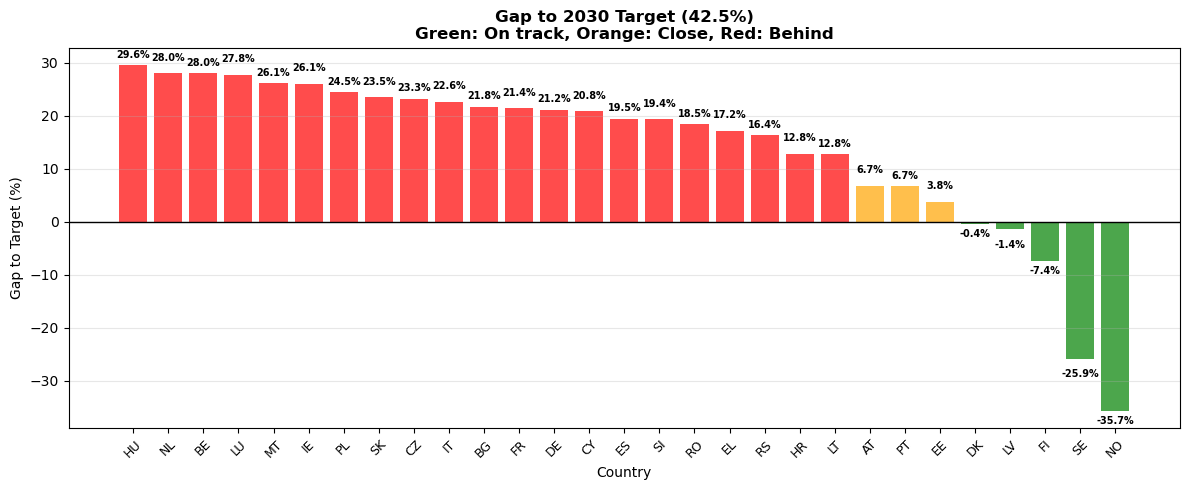

In [804]:
plot_gap_to_target(predictions_2030_results)

In [805]:
def plot_renewable_predictions(predictions_results):
    """
    Plot current vs predicted 2030 renewable energy shares.
    """
    predictions_df = predictions_results['predictions_df']
    predictions_sorted = predictions_df.sort_values('predicted_2030', ascending=True)
    
    x = np.arange(len(predictions_sorted))
    width = 0.35
    
    plt.figure(figsize=(9, 4))
    ax = plt.gca()
    
    bars1 = ax.bar(x - width/2, predictions_sorted['current_renewable_share'], width,
                   label='Current (2024)', color='lightblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, predictions_sorted['predicted_2030'], width,
                   label='ML Prediction 2030', color='darkblue', alpha=0.8)
    
    ax.axhline(y=42.5, color='red', linestyle='--', linewidth=2, label='EU Target (42.5%)')
    
    ax.set_xlabel('Countries (sorted by predicted performance)')
    ax.set_ylabel('Renewable Energy Share (%)')
    ax.set_title('2030 Renewable Energy Predictions vs Current Performance', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(predictions_sorted['country'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

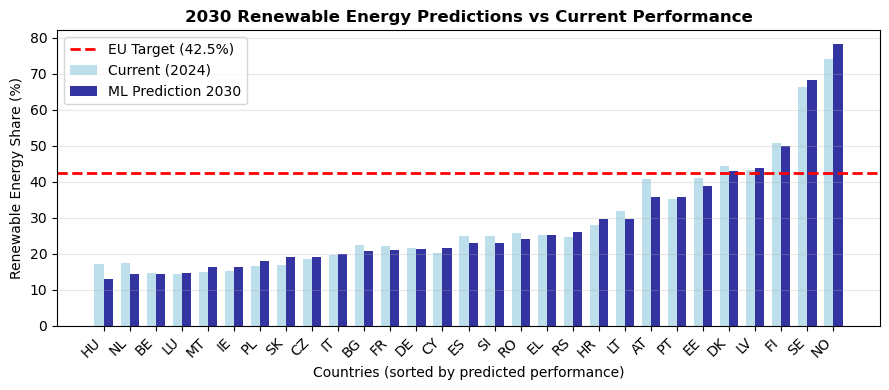

In [806]:
plot_renewable_predictions(predictions_2030_results)

---

### POLICY RECOMMENDATIONS

In [744]:
def generate_policy_recommendations(main_drivers_df, predictions_2030_results):
    """
    Generates actionable policy recommendations based on the identified main drivers
    and the 2030 target predictions.
    
    Args:
        main_drivers_df (pd.DataFrame): DataFrame showing the feature importance of main drivers.
        predictions_2030_results (dict): Dictionary containing the 2030 prediction results.
        
    Returns:
        dict: A dictionary containing the main drivers and a list of priority countries.
    """
    print("="*50)
    
    # Identify the top drivers from the feature importance analysis.
    top_drivers = main_drivers_df.head(3)
    
    print("Focus Areas for Accelerating Energy Transition:")
    for _, driver in top_drivers.iterrows():
        if 'rd_intensity' in driver['feature']:
            print(f"   Increase R&D Investment (Current impact: {driver['importance']:.1%})")
        elif 'education' in driver['feature']:
            print(f"   Enhance Tertiary Education (Current impact: {driver['importance']:.1%})")
        elif 'efficiency' in driver['feature']:
            print(f"   Improve Energy Efficiency (Current impact: {driver['importance']:.1%})")
    
    # Identify countries that are significantly behind their 2030 targets (gap > 10%).
    lagging_countries = predictions_2030_results['predictions_df'][
        predictions_2030_results['predictions_df']['gap_to_target'] > 10
    ]['country'].tolist()
    
    print(f"\n Priority Countries for Intervention: {', '.join(lagging_countries)}")
    
    policy_recommendations = {
        'main_drivers': main_drivers_df,
        'priority_countries': lagging_countries
    }
    
    return policy_recommendations

In [745]:
policy_recommendations = generate_policy_recommendations(main_drivers, predictions_2030_results)

Focus Areas for Accelerating Energy Transition:
   Increase R&D Investment (Current impact: 16.2%)

 Priority Countries for Intervention: BE, BG, CY, CZ, DE, EL, ES, FR, HR, HU, IE, IT, LT, LU, MT, NL, PL, RO, RS, SI, SK


---

### Final Overview

In [818]:
def plot_target_achievement_overview(predictions_results):
    """
    Plot 2030 Target Achievement Overview:
    - Number of countries on track vs behind
    - Average current share, average predicted share, and EU target percentages
    """
    predictions_df = predictions_results['predictions_df']
    
    target_achievement = predictions_df['predicted_2030'] >= 42.5
    current_vs_target = pd.DataFrame({
        'Metric': ['Countries on track', 'Countries behind', 'Avg current share', 'Avg predicted', 'EU Target'],
        'Value': [target_achievement.sum(), (~target_achievement).sum(), 
                 predictions_df['current_renewable_share'].mean(),
                 predictions_df['predicted_2030'].mean(), 42.5],
        'Type': ['Count', 'Count', 'Percentage', 'Percentage', 'Target']
    })
    
    count_data = current_vs_target[current_vs_target['Type'] == 'Count']
    perc_data = current_vs_target[current_vs_target['Type'].isin(['Percentage', 'Target'])]
    
    plt.figure(figsize=(9, 4))
    ax = plt.gca()
    
    # Plot counts (left y-axis)
    bars_count = ax.bar(['On Track', 'Behind'], count_data['Value'], 
                        color=['green', 'red'], alpha=0.7, width=0.4)
    ax.set_ylabel('Number of Countries', color='black')
    ax.set_title('2030 Target Achievement Overview', fontweight='bold')
    
    for bar, value in zip(bars_count, count_data['Value']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{int(value)}', ha='center', va='bottom', fontweight='bold')
    
    # Create second y-axis (right) for percentages
    ax_twin = ax.twinx()
    x_pos = [2, 3, 4]  # Positions for percentage bars
    bars_perc = ax_twin.bar(x_pos, perc_data['Value'], 
                            color=['blue', 'darkblue', 'red'], alpha=0.7, width=0.4)
    ax_twin.set_ylabel('Renewable Share (%)', color='blue')
    ax_twin.tick_params(axis='y', labelcolor='blue')
    
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['On Track', 'Behind', 'Avg Current', 'Avg Predicted', 'EU Target'])
    
    for bar, value in zip(bars_perc, perc_data['Value']):
        ax_twin.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', color='blue')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_target_achievement_overview(predictions_results):
    """
    Plot 2030 Target Achievement Overview:
    - Number of countries on track vs behind
    - Average current share, average predicted share, and EU target percentages

    This version is designed to be visually stunning with enhanced aesthetics,
    and a more compact figure size.
    """
    predictions_df = predictions_results['predictions_df']
    
    target_achievement = predictions_df['predicted_2030'] >= 42.5
    current_vs_target = pd.DataFrame({
        'Metric': ['Countries on track', 'Countries behind', 'Avg current share', 'Avg predicted', 'EU Target'],
        'Value': [target_achievement.sum(), (~target_achievement).sum(), 
                 predictions_df['current_renewable_share'].mean(),
                 predictions_df['predicted_2030'].mean(), 42.5],
        'Type': ['Count', 'Count', 'Percentage', 'Percentage', 'Target']
    })
    
    # Separate data for counts and percentages
    count_data = current_vs_target[current_vs_target['Type'] == 'Count'].copy()
    perc_data = current_vs_target[current_vs_target['Type'].isin(['Percentage', 'Target'])].copy()

    # Create the figure and a main axes with the new figsize
    fig, ax = plt.subplots(figsize=(9, 5)) 
    
    # --- Plotting Counts (Left Y-axis) ---
    bars_count = ax.bar(['On Track', 'Behind'], count_data['Value'], 
                        color=['#28a745', '#dc3545'], 
                        width=0.4, 
                        edgecolor='grey', linewidth=0.7, 
                        zorder=2) 
    
    ax.set_ylabel('Number of Countries', color='black', fontsize=11, fontweight='bold')
    ax.set_title('2030 Renewable Energy Target Achievement Overview', 
                 fontsize=14, fontweight='bold', pad=15, color='#333333') 
    
    # Add count labels on top of bars
    for bar in bars_count:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.3, 
                f'{int(yval)}', ha='center', va='bottom', 
                fontsize=10, color='black', fontweight='bold')
    
    ax.tick_params(axis='y', labelsize=9, colors='black')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True) 

    # --- Create Second Y-axis for Percentages (Right Y-axis) ---
    ax_twin = ax.twinx()
    
    # Positions for percentage bars, adjusted to avoid overlap with count bars
    x_pos_perc = [2.2, 3.2, 4.2] 
    
    bars_perc = ax_twin.bar(x_pos_perc, perc_data['Value'], 
                            color=['#007bff', '#17a2b8', '#fd7e14'], 
                            width=0.4, 
                            edgecolor='grey', linewidth=0.7,
                            zorder=2) 

    ax_twin.set_ylabel('Renewable Share (%)', color='#007bff', fontsize=11, fontweight='bold')
    ax_twin.tick_params(axis='y', labelcolor='#007bff', labelsize=9)
    ax_twin.yaxis.set_major_formatter(mtick.PercentFormatter()) 

    # Add percentage labels on top of bars
    for bar in bars_perc:
        yval = bar.get_height()
        ax_twin.text(bar.get_x() + bar.get_width()/2, yval + 0.8, 
                     f'{yval:.1f}%', ha='center', va='bottom', 
                     fontsize=10, color='black', fontweight='bold') 
    
    # --- X-axis Labels and Layout ---
    all_x_labels = ['On Track', 'Behind', 'Avg Current Share', 'Avg Predicted Share', 'EU Target']
    
    ax.set_xticks([0, 1, x_pos_perc[0], x_pos_perc[1], x_pos_perc[2]])
    ax.set_xticklabels(all_x_labels, fontsize=10, rotation=0, ha='center') 

    # --- General Enhancements ---
    ax.grid(axis='y', linestyle='--', alpha=0.6, zorder=1) 
    ax_twin.grid(axis='y', linestyle='--', alpha=0.3, zorder=1) 

    # Set y-axis limits to ensure space for labels (adjusted for smaller figure)
    ax.set_ylim(0, count_data['Value'].max() * 1.25) 
    ax_twin.set_ylim(0, perc_data['Value'].max() * 1.25)

    # Remove spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax_twin.spines['top'].set_visible(False)
    ax_twin.spines['left'].set_visible(False)
    
    plt.tight_layout() 
    plt.show()

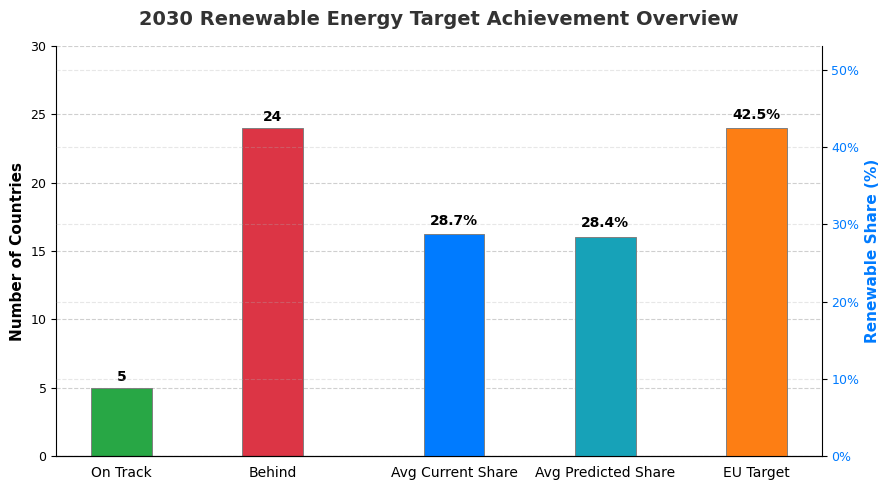

In [824]:
plot_target_achievement_overview(predictions_2030_results)